# IMPORTS

In [1]:
import os
import math
import time
import torch
import random
import warnings
import numpy as np
import pandas as pd
import torch.nn as nn
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, f1_score, classification_report
from accelerate import Accelerator, notebook_launcher
from torch.multiprocessing import Manager
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertModel, BertPreTrainedModel, BertConfig, BertForSequenceClassification

# SETUP

In [2]:
warnings.filterwarnings('ignore')

In [3]:
if os.path.exists('/kaggle/working/results') == False:
    os.mkdir('/kaggle/working/results')

if os.path.exists('/kaggle/working/acquired_data') == False:
    os.mkdir('/kaggle/working/acquired_data')

In [4]:
def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic=True
    torch.backends.cudnn.benchmark=False

set_seed(42)

# GLOBAL VARIABLES

In [5]:
manager = Manager()

# Shared resources
accuracies = manager.list()
f1_micros = manager.list()
f1_macros = manager.list()
data_used = manager.list()
sampling_dur = manager.list()
new_samples = manager.list()

# Non shared resources
filename = 'netifier-kmeans-kfold'
epochs = 10
batch_size = 32
sequence_length = 96
min_increment = 200

# LOAD AND PREPROCESS DATA

In [6]:
train_data = pd.read_csv('/kaggle/input/netifier/processed_train.csv', encoding='latin-1')
val_data = pd.read_csv('/kaggle/input/netifier/processed_test.csv', encoding='latin-1')

data = pd.concat([train_data, val_data], ignore_index=True)
data.shape

(7773, 7)

In [7]:
data.head()

,original_text,source,pornografi,sara,radikalisme,pencemaran_nama_baik,processed_text
0,[QUOTE=jessepinkman16;5a50ac34d89b093f368b456e...,kaskus,0,0,0,1,jabar memang provinsi barokah boleh juga dan n...
1,"@verosvante kita2 aja nitizen yang pada kepo,t...",instagram,0,0,0,0,kita saja nitizen yang pada penasaran toh kelu...
2,"""#SidangAhok smg sipenista agama n ateknya mat...",twitter,0,1,1,1,sidangahok semoga sipenista agama dan ateknya ...
3,@bolususulembang.jkt barusan baca undang2 ini....,instagram,0,0,0,0,jakarta barusan baca undang ini tetap dibedaka...
4,bikin anak mulu lu nof \nkaga mikir apa kasian...,kaskus,0,0,0,0,buat anak melulu kamu nof nkaga mikir apa kasi...


# BUILD DATASET & DATALOADERS

In [8]:
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from torch.utils.data import Dataset
import numpy as np
import torch

# Define custom Dataset class
class NetifierDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=96):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        labels = self.labels[idx]
        encoding = self.tokenizer(text, truncation=True, padding='max_length', max_length=self.max_length, return_tensors='pt')
        item = {key: val.squeeze() for key, val in encoding.items()}
        item['labels'] = torch.tensor(labels, dtype=torch.float)
        return item

# Initialize BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('indobenchmark/indobert-base-p1')

tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

In [9]:
def get_dataloaders(X_train, y_train, X_val, y_val, sequence_length=96, num_workers=4):
    train_dataset = NetifierDataset(X_train, y_train, tokenizer, max_length=sequence_length)
    val_dataset = NetifierDataset(X_val, y_val, tokenizer, max_length=sequence_length)
    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=num_workers
    )
    val_loader = torch.utils.data.DataLoader(
        val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=num_workers
    )

    return train_loader, val_loader

# TRAIN THE MODEL

In [10]:
def compute_metrics(p):
    preds = torch.tensor(p.predictions) # Sigmoid and threshold for multi-label
    labels = torch.tensor(p.label_ids)

    # Hamming accuracy: proportion of correctly predicted labels over total labels
    accuracy = (preds == labels).float().mean().item()

    # Standard multi-label precision, recall, and F1 metrics
    precision, recall, f1_micro, _ = precision_recall_fscore_support(labels, preds, average='micro', zero_division=0)
    _, _, f1_macro, _ = precision_recall_fscore_support(labels, preds, average='macro', zero_division=0)

    report = classification_report(
        labels, 
        preds, 
        target_names=['pornografi', 'sara', 'radikalisme', 'pencemaran_nama_baik'],
        zero_division=0
    ) 

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_micro': f1_micro,
        'f1_macro': f1_macro,
        'report': report
    }

In [11]:
def train_model(current_train_size, train_indices, metrics, trials, seed, X_train_fold, y_train_fold, X_val_fold, y_val_fold, label_columns):
    accelerator = Accelerator(mixed_precision='fp16')  # Initialize the accelerator
    device = accelerator.device

    accelerator.print(f"Fold {trials + 1} - Training with {current_train_size} samples...")

    with accelerator.main_process_first():
        model = BertForSequenceClassification.from_pretrained(
            'indobenchmark/indobert-base-p1',
            num_labels=len(label_columns),
            problem_type="multi_label_classification"
        )

    # Freeze the first few layers of the encoder
    for name, param in model.named_parameters():
        if "encoder.layer" in name:
            layer_num = name.split(".")[3]
            try:
                if int(layer_num) < 6:
                    param.requires_grad = False
            except ValueError:
                continue

    # Define DataLoaders using the fold's data
    current_X_train = [X_train_fold[i] for i in train_indices]
    current_y_train = [y_train_fold[i] for i in train_indices]
    train_loader, val_loader = get_dataloaders(current_X_train, current_y_train, X_val_fold, y_val_fold)

    # Define optimizer and loss function
    optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5, weight_decay=0.01)
    loss_fn = torch.nn.BCEWithLogitsLoss()

    # Prepare everything with Accelerator
    model, optimizer, train_loader, val_loader = accelerator.prepare(
        model, optimizer, train_loader, val_loader
    )

    best_result = None
    start_time = time.time()

    for epoch in range(epochs):
        model.train()
        epoch_loss = 0

        for batch in train_loader:
            inputs = {key: val for key, val in batch.items() if key != 'labels'}
            labels = batch['labels']

            optimizer.zero_grad()
            outputs = model(**inputs)
            loss = loss_fn(outputs.logits, labels)
            accelerator.backward(loss)
            optimizer.step()

            epoch_loss += loss.item()

        # Evaluation
        model.eval()
        all_preds = []
        all_labels = []
        
        with torch.no_grad():
            for batch in val_loader:
                inputs = {key: val for key, val in batch.items() if key != 'labels'}
                labels = batch['labels']
                
                outputs = model(**inputs)
                preds = torch.sigmoid(outputs.logits).round()

                # Gather predictions and labels from all devices
                all_preds.append(accelerator.gather(preds))
                all_labels.append(accelerator.gather(labels))

        all_preds = torch.cat(all_preds).cpu().numpy()
        all_labels = torch.cat(all_labels).cpu().numpy()

        result = compute_metrics(type('EvalOutput', (object,), {'predictions': all_preds, 'label_ids': all_labels}))

        if best_result is None or result['f1_micro'] >= best_result['f1_micro']:
            accelerator.wait_for_everyone()
            unwrapped_model = accelerator.unwrap_model(model)
            unwrapped_model.save_pretrained(
                f'{filename}-fold-{trials + 1}-model',
                is_main_process=accelerator.is_main_process,
                save_function=accelerator.save,
            )
            best_result = result
        
        accelerator.print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {round(epoch_loss / len(train_loader), 4)}, Accuracy: {round(result['accuracy'], 4)}, F1 Micro: {round(result['f1_micro'], 4)}, F1 Macro: {round(result['f1_macro'], 4)}")

    end_time = time.time()
    duration = end_time - start_time
    
    accelerator.print(f"Best result for {current_train_size} samples: F1 Micro: {round(best_result['f1_micro'], 4)}")
    accelerator.print(best_result['report'])
    
    # Update the shared lists
    if accelerator.is_local_main_process:
        metrics[0].append(current_train_size)
        metrics[1].append(best_result['accuracy'])
        metrics[2].append(best_result['f1_micro'])
        metrics[3].append(best_result['f1_macro'])

# PLOT THE RESULTS

In [12]:
import matplotlib.pyplot as plt

def plot_result(data_used, accuracies, f1_micros, f1_macros):
    fig, axs = plt.subplots(1, 3, figsize=(21, 5))
    data_used = [round(data / total_data * 100, 1) for data in data_used]

    # Plot for Accuracy
    axs[0].plot(data_used, accuracies, label="Accuracy", color="blue")
    axs[0].set_xlabel("Percentage of data used")
    axs[0].set_title("Accuracy")
    axs[0].set_xticks(data_used)

    # Plot for F1 Micro
    axs[1].plot(data_used, f1_micros, label="F1 Micro", color="orange")
    axs[1].set_xlabel("Percentage of data used")
    axs[1].set_title("F1 Micro")
    axs[1].set_xticks(data_used)

    # Plot for F1 Macro
    axs[2].plot(data_used, f1_macros, label="F1 Macro", color="green")
    axs[2].set_xlabel("Percentage of data used")
    axs[2].set_title("F1 Macro")
    axs[2].set_xticks(data_used)

    # Adjust layout and show the plots
    plt.tight_layout()
    plt.show()

# QUERY STRATEGY

In [13]:
def kmeans_clustering_sampling(model, X_pool, train_indices, remaining_indices, tokenizer, sampling_dur, new_samples, trials, X_train_fold, y_train_fold, n_clusters=min_increment):
    accelerator = Accelerator(mixed_precision="fp16")
    device = accelerator.device

    model.to(device)

    current_train_size = len(train_indices)
    dataset = NetifierDataset(X_pool, np.zeros((len(X_pool), 4)), tokenizer, max_length=sequence_length)
    dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        num_workers=4,
        pin_memory=True,
    )

    model.eval()
    start_time = time.time()
    embeddings = []
    
    with torch.no_grad():
        for data in dataloader:
            input_ids = data['input_ids'].to(device)
            attention_mask = data['attention_mask'].to(device)
            outputs = model.base_model(input_ids=input_ids, attention_mask=attention_mask)
            hidden_states = outputs.last_hidden_state.mean(dim=1)  # Mean of hidden states for vector representation
            embeddings.append(hidden_states.cpu().numpy())
    
    # Convert embeddings list to numpy array
    embeddings = np.vstack(embeddings)
    embeddings = np.array(embeddings)
    
    collected_indices = set()  # Initialize set to store selected indices
    thresholds = []

    accelerator.wait_for_everyone()

    if accelerator.is_local_main_process:
        target_samples = len(embeddings[:math.ceil(0.1 * len(embeddings))])
    
        # Check nearest checkpoint
        nearest_cp = 0
        arrived_at_cp = False
        for cp in checkpoints:
            if cp > current_train_size:
                nearest_cp = cp
                break
                
        # Determine number of maximum samples to be acquired
        if target_samples <= n_clusters and n_clusters < nearest_cp - current_train_size:
            target_samples = n_clusters
        elif target_samples > n_clusters and target_samples < nearest_cp - current_train_size:
            target_samples = target_samples
        else:
            arrived_at_cp = True
            target_samples = nearest_cp - current_train_size

        # No clustering needed when there's little data left
        if current_train_size >= checkpoints[len(checkpoints)-1] - min_increment:
            end_time = time.time()
            duration = end_time - start_time
            
            temp = train_indices.copy()
            temp.extend(remaining_indices)
            
            # Save acquired data up to checkpoint
            acquired_data = pd.DataFrame({
                'processed_text': [X_train_fold[i] for i in temp],
                'pornografi': [y_train_fold[i][0] for i in temp],
                'sara': [y_train_fold[i][1] for i in temp],
                'radikalisme': [y_train_fold[i][2] for i in temp],
                'pencemaran_nama_baik': [y_train_fold[i][3] for i in temp],
            })
            acquired_data.to_csv(f'acquired_data/{filename}-{trials+1}-data-{nearest_cp}.csv', index=False)

            print("Nearest checkpoint:", nearest_cp)
            print("Acquired samples:", len(remaining_indices))
            print(f"Sampling duration: {duration} seconds")
            
            sampling_dur.append(duration)
            for i in remaining_indices:
                new_samples.append(i)
        else:
            # Cluster the data based on its embeddings
            kmeans=KMeans(n_clusters=n_clusters, n_init=1)
            kmeans.fit(embeddings)
            
            for cluster_id in range(n_clusters):
                # Cluster center and indices of samples in the current cluster
                cluster_center = kmeans.cluster_centers_[cluster_id]
                cluster_indices = np.where(kmeans.labels_ == cluster_id)[0]
            
                if cluster_indices.size == 0:
                    # Skip clusters with no members
                    print(f"Cluster {cluster_id} has no members, skipping.")
                    continue
            
                # Calculate distances of each point in the cluster from the cluster center
                cluster_distances = np.linalg.norm(embeddings[cluster_indices] - cluster_center, axis=1)
            
                # Determine the local threshold (10th percentile of closest distances to cluster center)
                local_threshold = np.percentile(cluster_distances, 90)
                thresholds.append(local_threshold)
            
                below_threshold_indices = cluster_indices[cluster_distances >= local_threshold]
                collected_indices.update(below_threshold_indices)

            # To handle multiple points with same distance
            if len(collected_indices) > target_samples:
                collected_indices = np.array(list(collected_indices))
                np.random.shuffle(collected_indices)
                collected_indices = collected_indices[:target_samples]
                
            end_time = time.time() 
            duration = end_time - start_time 
    
            if arrived_at_cp:
                temp = train_indices.copy()
                temp.extend(collected_indices)
                
                # Save acquired data up to checkpoint
                acquired_data = pd.DataFrame({
                    'processed_text': [X_train_fold[i] for i in temp],
                    'pornografi': [y_train_fold[i][0] for i in temp],
                    'sara': [y_train_fold[i][1] for i in temp],
                    'radikalisme': [y_train_fold[i][2] for i in temp],
                    'pencemaran_nama_baik': [y_train_fold[i][3] for i in temp],
                })
        
                acquired_data.to_csv(f'acquired_data/{filename}-{trials+1}-data-{nearest_cp}.csv', index=False)
            
            print("Nearest checkpoint:", nearest_cp)
            # print(f"Thresholds: {thresholds}")
            print("Acquired samples:", len(collected_indices))
            print(f"Sampling duration: {duration} seconds")
        
            sampling_dur.append(duration)
            for i in collected_indices:
                new_samples.append(remaining_indices[i])

        # threshold_data = pd.DataFrame({
        #     'Threshold': thresholds
        # })
        # threshold_data.to_csv(f"results/{filename}-thresholds-{trials+1}-{current_train_size}.csv", index=False)

# MAIN LOOP

In [14]:
from sklearn.model_selection import KFold

N_SPLITS = 5
RANDOM_SEED = 42

# Prepare data for K-Fold
label_columns = data.columns[2:6]
X = data['processed_text'].values
y = data[label_columns].values
kf = KFold(n_splits=N_SPLITS, shuffle=True, random_state=RANDOM_SEED)

# Each element in these lists will be a list of metrics for one fold's learning curve
all_fold_accuracies = []
all_fold_f1_micros = []
all_fold_f1_macros = []
all_fold_data_used = []

for fold, (train_index, val_index) in enumerate(kf.split(X)):
    print("===============================================")
    print(f"STARTING FOLD {fold + 1}/{N_SPLITS}")
    print("===============================================")

    X_train_fold, X_val_fold = X[train_index], X[val_index]
    y_train_fold, y_val_fold = y[train_index], y[val_index]

    # Shared resources for this fold's processes
    accuracies = manager.list()
    f1_micros = manager.list()
    f1_macros = manager.list()
    data_used = manager.list()
    sampling_dur = manager.list()
    
    # Set seed for reproducibility within the fold
    set_seed(RANDOM_SEED + fold)
    
    # Define the initial labeled pool from the current fold's training data
    total_train_fold_size = len(X_train_fold) + len(X_val_fold)
    initial_train_size = int(0.05 * total_train_fold_size)
    
    train_indices = np.random.choice(range(len(X_train_fold)), initial_train_size, replace=False).tolist()
    remaining_indices = list(set(range(len(X_train_fold))) - set(train_indices))
    current_train_size = initial_train_size

    # Adjust checkpoints based on the current fold's training size
    checkpoints = [
        # int(0.1 * total_train_fold_size)
        int(0.5 * total_train_fold_size), 
        int(0.6 * total_train_fold_size),
        int(0.7 * total_train_fold_size),
        len(X_train_fold)
    ]
    
    fold_start_time = time.time()
    
    while current_train_size < total_train_fold_size:
        # 1. Train the model on the current labeled set
        train_args = (
            current_train_size, train_indices, (data_used, accuracies, f1_micros, f1_macros),
            fold, RANDOM_SEED + fold, X_train_fold, y_train_fold, X_val_fold, y_val_fold, label_columns
        )
        notebook_launcher(train_model, train_args, num_processes=2)
        
        # Stop if we've reached the last checkpoint
        if current_train_size >= checkpoints[-1]:
            break

        model = BertForSequenceClassification.from_pretrained(f'{filename}-fold-{fold + 1}-model')
        
        # 3. Perform query strategy to select new samples
        new_samples_shared = manager.list()
        X_pool = [X_train_fold[i] for i in remaining_indices]
        sampling_args = (model, X_pool, train_indices, remaining_indices, tokenizer, sampling_dur, new_samples_shared, fold, X_train_fold, y_train_fold)
        notebook_launcher(kmeans_clustering_sampling, sampling_args, num_processes=2)
        
        # 4. Update the pools
        newly_acquired_indices = list(new_samples_shared)
        train_indices.extend(newly_acquired_indices)
        remaining_indices = list(set(remaining_indices) - set(newly_acquired_indices))
    
        current_train_size = len(train_indices)
        print(f"\nFold {fold + 1} - New train size: {current_train_size}\n")
    
    fold_end_time = time.time()
    print(f"\nFOLD {fold + 1} COMPLETED in {fold_end_time - fold_start_time:.2f} seconds")
    
    # Store the results for this fold
    all_fold_data_used.append(list(data_used))
    all_fold_accuracies.append(list(accuracies))
    all_fold_f1_micros.append(list(f1_micros))
    all_fold_f1_macros.append(list(f1_macros))

STARTING FOLD 1/5
Launching training on 2 GPUs.
Fold 1 - Training with 388 samples...


pytorch_model.bin:   0%|          | 0.00/498M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.5963, Accuracy: 0.7902, F1 Micro: 0.0, F1 Macro: 0.0
Epoch 2/10, Train Loss: 0.5233, Accuracy: 0.7902, F1 Micro: 0.0, F1 Macro: 0.0
Epoch 3/10, Train Loss: 0.4851, Accuracy: 0.8166, F1 Micro: 0.2367, F1 Macro: 0.1613
Epoch 4/10, Train Loss: 0.4274, Accuracy: 0.8252, F1 Micro: 0.3327, F1 Macro: 0.227
Epoch 5/10, Train Loss: 0.3978, Accuracy: 0.8386, F1 Micro: 0.4661, F1 Macro: 0.3619
Epoch 6/10, Train Loss: 0.349, Accuracy: 0.8506, F1 Micro: 0.5631, F1 Macro: 0.5253
Epoch 7/10, Train Loss: 0.3106, Accuracy: 0.862, F1 Micro: 0.652, F1 Macro: 0.6434
Epoch 8/10, Train Loss: 0.2486, Accuracy: 0.8617, F1 Micro: 0.6641, F1 Macro: 0.6497
Epoch 9/10, Train Loss: 0.2302, Accuracy: 0.8678, F1 Micro: 0.6874, F1 Macro: 0.684
Epoch 10/10, Train Loss: 0.1741, Accuracy: 0.8681, F1 Micro: 0.6544, F1 Macro: 0.6387
Best result for 388 samples: F1 Micro: 0.6874
                      precision    recall  f1-score   support

          pornografi       0.91      0.79      0.85      

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.5315, Accuracy: 0.815, F1 Micro: 0.2312, F1 Macro: 0.1686
Epoch 2/10, Train Loss: 0.4107, Accuracy: 0.83, F1 Micro: 0.3592, F1 Macro: 0.2442
Epoch 3/10, Train Loss: 0.3171, Accuracy: 0.8473, F1 Micro: 0.4898, F1 Macro: 0.3883
Epoch 4/10, Train Loss: 0.2693, Accuracy: 0.8727, F1 Micro: 0.6832, F1 Macro: 0.6759
Epoch 5/10, Train Loss: 0.1998, Accuracy: 0.8773, F1 Micro: 0.6714, F1 Macro: 0.6569
Epoch 6/10, Train Loss: 0.1633, Accuracy: 0.8755, F1 Micro: 0.6506, F1 Macro: 0.6303
Epoch 7/10, Train Loss: 0.1441, Accuracy: 0.8773, F1 Micro: 0.6768, F1 Macro: 0.6608
Epoch 8/10, Train Loss: 0.1081, Accuracy: 0.878, F1 Micro: 0.6914, F1 Macro: 0.6794
Epoch 9/10, Train Loss: 0.0868, Accuracy: 0.8813, F1 Micro: 0.6898, F1 Macro: 0.6777
Epoch 10/10, Train Loss: 0.0654, Accuracy: 0.8816, F1 Micro: 0.7067, F1 Macro: 0.6963
Best result for 971 samples: F1 Micro: 0.7067
                      precision    recall  f1-score   support

          pornografi       0.91      0.83   

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.4855, Accuracy: 0.8144, F1 Micro: 0.2215, F1 Macro: 0.1668
Epoch 2/10, Train Loss: 0.3588, Accuracy: 0.8505, F1 Micro: 0.5436, F1 Macro: 0.4915
Epoch 3/10, Train Loss: 0.2901, Accuracy: 0.8736, F1 Micro: 0.6739, F1 Macro: 0.6598
Epoch 4/10, Train Loss: 0.2276, Accuracy: 0.8863, F1 Micro: 0.7178, F1 Macro: 0.7044
Epoch 5/10, Train Loss: 0.1833, Accuracy: 0.8859, F1 Micro: 0.7171, F1 Macro: 0.7108
Epoch 6/10, Train Loss: 0.1469, Accuracy: 0.8905, F1 Micro: 0.7307, F1 Macro: 0.7241
Epoch 7/10, Train Loss: 0.1165, Accuracy: 0.8891, F1 Micro: 0.7009, F1 Macro: 0.676
Epoch 8/10, Train Loss: 0.0808, Accuracy: 0.8883, F1 Micro: 0.6948, F1 Macro: 0.6724
Epoch 9/10, Train Loss: 0.0786, Accuracy: 0.8909, F1 Micro: 0.7258, F1 Macro: 0.7195
Epoch 10/10, Train Loss: 0.0561, Accuracy: 0.8872, F1 Micro: 0.6877, F1 Macro: 0.6619
Best result for 1496 samples: F1 Micro: 0.7307
                      precision    recall  f1-score   support

          pornografi       0.93      0.8

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.4697, Accuracy: 0.8278, F1 Micro: 0.3393, F1 Macro: 0.2291
Epoch 2/10, Train Loss: 0.3401, Accuracy: 0.8648, F1 Micro: 0.5997, F1 Macro: 0.5612
Epoch 3/10, Train Loss: 0.2579, Accuracy: 0.8863, F1 Micro: 0.7007, F1 Macro: 0.688
Epoch 4/10, Train Loss: 0.2147, Accuracy: 0.8891, F1 Micro: 0.7292, F1 Macro: 0.7115
Epoch 5/10, Train Loss: 0.1598, Accuracy: 0.8905, F1 Micro: 0.7199, F1 Macro: 0.7097
Epoch 6/10, Train Loss: 0.137, Accuracy: 0.8911, F1 Micro: 0.7246, F1 Macro: 0.7157
Epoch 7/10, Train Loss: 0.0961, Accuracy: 0.8878, F1 Micro: 0.7305, F1 Macro: 0.7266
Epoch 8/10, Train Loss: 0.0764, Accuracy: 0.8886, F1 Micro: 0.7218, F1 Macro: 0.715
Epoch 9/10, Train Loss: 0.0569, Accuracy: 0.8895, F1 Micro: 0.7115, F1 Macro: 0.7
Epoch 10/10, Train Loss: 0.0463, Accuracy: 0.8872, F1 Micro: 0.7278, F1 Macro: 0.7233
Best result for 1969 samples: F1 Micro: 0.7305
                      precision    recall  f1-score   support

          pornografi       0.92      0.85    

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.4658, Accuracy: 0.8358, F1 Micro: 0.3998, F1 Macro: 0.3142
Epoch 2/10, Train Loss: 0.3187, Accuracy: 0.8703, F1 Micro: 0.6186, F1 Macro: 0.6023
Epoch 3/10, Train Loss: 0.2569, Accuracy: 0.8869, F1 Micro: 0.6935, F1 Macro: 0.688
Epoch 4/10, Train Loss: 0.1994, Accuracy: 0.8933, F1 Micro: 0.7227, F1 Macro: 0.7101
Epoch 5/10, Train Loss: 0.1549, Accuracy: 0.8966, F1 Micro: 0.7543, F1 Macro: 0.7531
Epoch 6/10, Train Loss: 0.1161, Accuracy: 0.8941, F1 Micro: 0.7244, F1 Macro: 0.7123
Epoch 7/10, Train Loss: 0.0809, Accuracy: 0.893, F1 Micro: 0.7437, F1 Macro: 0.7414
Epoch 8/10, Train Loss: 0.0651, Accuracy: 0.8967, F1 Micro: 0.7415, F1 Macro: 0.7368
Epoch 9/10, Train Loss: 0.0512, Accuracy: 0.8927, F1 Micro: 0.7447, F1 Macro: 0.7435
Epoch 10/10, Train Loss: 0.0403, Accuracy: 0.8945, F1 Micro: 0.7301, F1 Macro: 0.7243
Best result for 2394 samples: F1 Micro: 0.7543
                      precision    recall  f1-score   support

          pornografi       0.91      0.86

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.4494, Accuracy: 0.8366, F1 Micro: 0.4117, F1 Macro: 0.294
Epoch 2/10, Train Loss: 0.2989, Accuracy: 0.8781, F1 Micro: 0.6493, F1 Macro: 0.6267
Epoch 3/10, Train Loss: 0.2343, Accuracy: 0.883, F1 Micro: 0.6511, F1 Macro: 0.6256
Epoch 4/10, Train Loss: 0.1983, Accuracy: 0.8975, F1 Micro: 0.723, F1 Macro: 0.7116
Epoch 5/10, Train Loss: 0.1416, Accuracy: 0.8994, F1 Micro: 0.7515, F1 Macro: 0.7473
Epoch 6/10, Train Loss: 0.1062, Accuracy: 0.8927, F1 Micro: 0.7197, F1 Macro: 0.7026
Epoch 7/10, Train Loss: 0.0831, Accuracy: 0.892, F1 Micro: 0.7472, F1 Macro: 0.75
Epoch 8/10, Train Loss: 0.0619, Accuracy: 0.8998, F1 Micro: 0.7455, F1 Macro: 0.7374
Epoch 9/10, Train Loss: 0.047, Accuracy: 0.8983, F1 Micro: 0.748, F1 Macro: 0.746
Epoch 10/10, Train Loss: 0.0354, Accuracy: 0.8956, F1 Micro: 0.738, F1 Macro: 0.7342
Best result for 2777 samples: F1 Micro: 0.7515
                      precision    recall  f1-score   support

          pornografi       0.91      0.89      0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.4414, Accuracy: 0.847, F1 Micro: 0.4956, F1 Macro: 0.4325
Epoch 2/10, Train Loss: 0.2865, Accuracy: 0.8864, F1 Micro: 0.7074, F1 Macro: 0.6923
Epoch 3/10, Train Loss: 0.228, Accuracy: 0.8928, F1 Micro: 0.7245, F1 Macro: 0.7071
Epoch 4/10, Train Loss: 0.1822, Accuracy: 0.8927, F1 Micro: 0.7481, F1 Macro: 0.7452
Epoch 5/10, Train Loss: 0.1388, Accuracy: 0.8931, F1 Micro: 0.7206, F1 Macro: 0.706
Epoch 6/10, Train Loss: 0.0981, Accuracy: 0.8944, F1 Micro: 0.757, F1 Macro: 0.7585
Epoch 7/10, Train Loss: 0.078, Accuracy: 0.8975, F1 Micro: 0.7405, F1 Macro: 0.7367
Epoch 8/10, Train Loss: 0.0605, Accuracy: 0.8963, F1 Micro: 0.7392, F1 Macro: 0.7317
Epoch 9/10, Train Loss: 0.0489, Accuracy: 0.8941, F1 Micro: 0.7478, F1 Macro: 0.7491
Epoch 10/10, Train Loss: 0.0337, Accuracy: 0.8961, F1 Micro: 0.7518, F1 Macro: 0.7497
Best result for 3122 samples: F1 Micro: 0.757
                      precision    recall  f1-score   support

          pornografi       0.93      0.87    

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.4337, Accuracy: 0.8562, F1 Micro: 0.5867, F1 Macro: 0.5723
Epoch 2/10, Train Loss: 0.281, Accuracy: 0.8834, F1 Micro: 0.6687, F1 Macro: 0.6425
Epoch 3/10, Train Loss: 0.2233, Accuracy: 0.8909, F1 Micro: 0.6917, F1 Macro: 0.6758
Epoch 4/10, Train Loss: 0.1873, Accuracy: 0.898, F1 Micro: 0.7318, F1 Macro: 0.7223
Epoch 5/10, Train Loss: 0.1397, Accuracy: 0.8998, F1 Micro: 0.758, F1 Macro: 0.7575
Epoch 6/10, Train Loss: 0.1041, Accuracy: 0.9016, F1 Micro: 0.7407, F1 Macro: 0.734
Epoch 7/10, Train Loss: 0.0748, Accuracy: 0.8981, F1 Micro: 0.7515, F1 Macro: 0.7494
Epoch 8/10, Train Loss: 0.064, Accuracy: 0.9003, F1 Micro: 0.7607, F1 Macro: 0.7597
Epoch 9/10, Train Loss: 0.0457, Accuracy: 0.8992, F1 Micro: 0.7518, F1 Macro: 0.7492
Epoch 10/10, Train Loss: 0.036, Accuracy: 0.898, F1 Micro: 0.7553, F1 Macro: 0.7521
Best result for 3432 samples: F1 Micro: 0.7607
                      precision    recall  f1-score   support

          pornografi       0.94      0.86     

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.4118, Accuracy: 0.8633, F1 Micro: 0.5943, F1 Macro: 0.5532
Epoch 2/10, Train Loss: 0.261, Accuracy: 0.893, F1 Micro: 0.7161, F1 Macro: 0.7018
Epoch 3/10, Train Loss: 0.2093, Accuracy: 0.8983, F1 Micro: 0.7528, F1 Macro: 0.7442
Epoch 4/10, Train Loss: 0.171, Accuracy: 0.9006, F1 Micro: 0.7444, F1 Macro: 0.7384
Epoch 5/10, Train Loss: 0.1285, Accuracy: 0.8989, F1 Micro: 0.7468, F1 Macro: 0.743
Epoch 6/10, Train Loss: 0.0979, Accuracy: 0.897, F1 Micro: 0.7542, F1 Macro: 0.7571
Epoch 7/10, Train Loss: 0.0677, Accuracy: 0.8998, F1 Micro: 0.7511, F1 Macro: 0.7458
Epoch 8/10, Train Loss: 0.0529, Accuracy: 0.8923, F1 Micro: 0.7531, F1 Macro: 0.7554
Epoch 9/10, Train Loss: 0.044, Accuracy: 0.9033, F1 Micro: 0.7633, F1 Macro: 0.7605
Epoch 10/10, Train Loss: 0.0326, Accuracy: 0.9031, F1 Micro: 0.7606, F1 Macro: 0.7571
Best result for 3711 samples: F1 Micro: 0.7633
                      precision    recall  f1-score   support

          pornografi       0.94      0.87    

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.4219, Accuracy: 0.8642, F1 Micro: 0.6115, F1 Macro: 0.5668
Epoch 2/10, Train Loss: 0.2723, Accuracy: 0.8916, F1 Micro: 0.7135, F1 Macro: 0.7016
Epoch 3/10, Train Loss: 0.2177, Accuracy: 0.8975, F1 Micro: 0.7549, F1 Macro: 0.7554
Epoch 4/10, Train Loss: 0.1778, Accuracy: 0.9008, F1 Micro: 0.754, F1 Macro: 0.744
Epoch 5/10, Train Loss: 0.137, Accuracy: 0.8973, F1 Micro: 0.7509, F1 Macro: 0.7464
Epoch 6/10, Train Loss: 0.1026, Accuracy: 0.9034, F1 Micro: 0.761, F1 Macro: 0.7563
Epoch 7/10, Train Loss: 0.0738, Accuracy: 0.8978, F1 Micro: 0.7545, F1 Macro: 0.75
Epoch 8/10, Train Loss: 0.0607, Accuracy: 0.8925, F1 Micro: 0.7609, F1 Macro: 0.7634
Epoch 9/10, Train Loss: 0.0406, Accuracy: 0.9022, F1 Micro: 0.7472, F1 Macro: 0.7351
Epoch 10/10, Train Loss: 0.0373, Accuracy: 0.8981, F1 Micro: 0.7485, F1 Macro: 0.7478
Best result for 3886 samples: F1 Micro: 0.761
                      precision    recall  f1-score   support

          pornografi       0.94      0.86     

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.4086, Accuracy: 0.8722, F1 Micro: 0.6483, F1 Macro: 0.617
Epoch 2/10, Train Loss: 0.2592, Accuracy: 0.8938, F1 Micro: 0.7299, F1 Macro: 0.7182
Epoch 3/10, Train Loss: 0.2111, Accuracy: 0.8994, F1 Micro: 0.7488, F1 Macro: 0.7439
Epoch 4/10, Train Loss: 0.1619, Accuracy: 0.9017, F1 Micro: 0.7638, F1 Macro: 0.7582
Epoch 5/10, Train Loss: 0.1277, Accuracy: 0.9002, F1 Micro: 0.7361, F1 Macro: 0.7262
Epoch 6/10, Train Loss: 0.0983, Accuracy: 0.8944, F1 Micro: 0.7547, F1 Macro: 0.7536
Epoch 7/10, Train Loss: 0.0717, Accuracy: 0.8963, F1 Micro: 0.7408, F1 Macro: 0.7331
Epoch 8/10, Train Loss: 0.0481, Accuracy: 0.8988, F1 Micro: 0.7439, F1 Macro: 0.7382
Epoch 9/10, Train Loss: 0.0396, Accuracy: 0.9008, F1 Micro: 0.7522, F1 Macro: 0.7474
Epoch 10/10, Train Loss: 0.0297, Accuracy: 0.898, F1 Micro: 0.7595, F1 Macro: 0.7596
Best result for 4120 samples: F1 Micro: 0.7638
                      precision    recall  f1-score   support

          pornografi       0.92      0.88

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.4062, Accuracy: 0.8664, F1 Micro: 0.5957, F1 Macro: 0.5779
Epoch 2/10, Train Loss: 0.2678, Accuracy: 0.8916, F1 Micro: 0.7478, F1 Macro: 0.75
Epoch 3/10, Train Loss: 0.2088, Accuracy: 0.9009, F1 Micro: 0.7522, F1 Macro: 0.7461
Epoch 4/10, Train Loss: 0.1657, Accuracy: 0.9009, F1 Micro: 0.7468, F1 Macro: 0.7448
Epoch 5/10, Train Loss: 0.1321, Accuracy: 0.9013, F1 Micro: 0.764, F1 Macro: 0.7614
Epoch 6/10, Train Loss: 0.0939, Accuracy: 0.8973, F1 Micro: 0.7603, F1 Macro: 0.7583
Epoch 7/10, Train Loss: 0.0669, Accuracy: 0.9055, F1 Micro: 0.7579, F1 Macro: 0.7467
Epoch 8/10, Train Loss: 0.0539, Accuracy: 0.8945, F1 Micro: 0.7571, F1 Macro: 0.7562
Epoch 9/10, Train Loss: 0.04, Accuracy: 0.9042, F1 Micro: 0.7505, F1 Macro: 0.7417
Epoch 10/10, Train Loss: 0.0333, Accuracy: 0.8991, F1 Micro: 0.7529, F1 Macro: 0.7522
Best result for 4330 samples: F1 Micro: 0.764
                      precision    recall  f1-score   support

          pornografi       0.94      0.88    

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.4145, Accuracy: 0.8778, F1 Micro: 0.6766, F1 Macro: 0.6527
Epoch 2/10, Train Loss: 0.2611, Accuracy: 0.8995, F1 Micro: 0.7626, F1 Macro: 0.7607
Epoch 3/10, Train Loss: 0.2081, Accuracy: 0.9003, F1 Micro: 0.751, F1 Macro: 0.7474
Epoch 4/10, Train Loss: 0.1757, Accuracy: 0.9014, F1 Micro: 0.7733, F1 Macro: 0.7743
Epoch 5/10, Train Loss: 0.1379, Accuracy: 0.9031, F1 Micro: 0.7518, F1 Macro: 0.75
Epoch 6/10, Train Loss: 0.1068, Accuracy: 0.8995, F1 Micro: 0.7635, F1 Macro: 0.7658
Epoch 7/10, Train Loss: 0.0718, Accuracy: 0.903, F1 Micro: 0.767, F1 Macro: 0.766
Epoch 8/10, Train Loss: 0.0574, Accuracy: 0.9017, F1 Micro: 0.7704, F1 Macro: 0.7711
Epoch 9/10, Train Loss: 0.0454, Accuracy: 0.9036, F1 Micro: 0.7697, F1 Macro: 0.7685
Epoch 10/10, Train Loss: 0.0305, Accuracy: 0.9034, F1 Micro: 0.7661, F1 Macro: 0.7598
Best result for 4530 samples: F1 Micro: 0.7733
                      precision    recall  f1-score   support

          pornografi       0.93      0.88    

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.4087, Accuracy: 0.8728, F1 Micro: 0.6557, F1 Macro: 0.6448
Epoch 2/10, Train Loss: 0.264, Accuracy: 0.8936, F1 Micro: 0.7594, F1 Macro: 0.7588
Epoch 3/10, Train Loss: 0.2081, Accuracy: 0.9038, F1 Micro: 0.7684, F1 Macro: 0.7643
Epoch 4/10, Train Loss: 0.1681, Accuracy: 0.907, F1 Micro: 0.7564, F1 Macro: 0.7533
Epoch 5/10, Train Loss: 0.136, Accuracy: 0.8991, F1 Micro: 0.7642, F1 Macro: 0.7624
Epoch 6/10, Train Loss: 0.0938, Accuracy: 0.9028, F1 Micro: 0.7708, F1 Macro: 0.7703
Epoch 7/10, Train Loss: 0.0761, Accuracy: 0.9038, F1 Micro: 0.7695, F1 Macro: 0.7669
Epoch 8/10, Train Loss: 0.0535, Accuracy: 0.9025, F1 Micro: 0.7604, F1 Macro: 0.7574
Epoch 9/10, Train Loss: 0.0439, Accuracy: 0.8927, F1 Micro: 0.764, F1 Macro: 0.7686
Epoch 10/10, Train Loss: 0.0365, Accuracy: 0.9039, F1 Micro: 0.7713, F1 Macro: 0.773
Best result for 4663 samples: F1 Micro: 0.7713
                      precision    recall  f1-score   support

          pornografi       0.94      0.88   

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.4006, Accuracy: 0.8669, F1 Micro: 0.5939, F1 Macro: 0.5644
Epoch 2/10, Train Loss: 0.2541, Accuracy: 0.8941, F1 Micro: 0.7273, F1 Macro: 0.701
Epoch 3/10, Train Loss: 0.2052, Accuracy: 0.9025, F1 Micro: 0.75, F1 Macro: 0.7467
Epoch 4/10, Train Loss: 0.1639, Accuracy: 0.9009, F1 Micro: 0.7742, F1 Macro: 0.7738
Epoch 5/10, Train Loss: 0.1322, Accuracy: 0.9041, F1 Micro: 0.7692, F1 Macro: 0.7682
Epoch 6/10, Train Loss: 0.0939, Accuracy: 0.8995, F1 Micro: 0.7582, F1 Macro: 0.7565
Epoch 7/10, Train Loss: 0.0699, Accuracy: 0.9011, F1 Micro: 0.7546, F1 Macro: 0.7492
Epoch 8/10, Train Loss: 0.053, Accuracy: 0.9027, F1 Micro: 0.7599, F1 Macro: 0.7572
Epoch 9/10, Train Loss: 0.0459, Accuracy: 0.9023, F1 Micro: 0.7669, F1 Macro: 0.7664
Epoch 10/10, Train Loss: 0.0318, Accuracy: 0.8983, F1 Micro: 0.764, F1 Macro: 0.7645
Best result for 4863 samples: F1 Micro: 0.7742
                      precision    recall  f1-score   support

          pornografi       0.93      0.89   

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.3867, Accuracy: 0.8828, F1 Micro: 0.6936, F1 Macro: 0.6847
Epoch 2/10, Train Loss: 0.2522, Accuracy: 0.8972, F1 Micro: 0.7349, F1 Macro: 0.7274
Epoch 3/10, Train Loss: 0.1942, Accuracy: 0.9034, F1 Micro: 0.752, F1 Macro: 0.7377
Epoch 4/10, Train Loss: 0.1605, Accuracy: 0.9058, F1 Micro: 0.7619, F1 Macro: 0.7547
Epoch 5/10, Train Loss: 0.1242, Accuracy: 0.9044, F1 Micro: 0.7619, F1 Macro: 0.7554
Epoch 6/10, Train Loss: 0.0964, Accuracy: 0.9006, F1 Micro: 0.7716, F1 Macro: 0.7712
Epoch 7/10, Train Loss: 0.0673, Accuracy: 0.9045, F1 Micro: 0.7599, F1 Macro: 0.7562
Epoch 8/10, Train Loss: 0.0491, Accuracy: 0.9042, F1 Micro: 0.7744, F1 Macro: 0.7715
Epoch 9/10, Train Loss: 0.0383, Accuracy: 0.9028, F1 Micro: 0.7733, F1 Macro: 0.7731
Epoch 10/10, Train Loss: 0.0318, Accuracy: 0.9038, F1 Micro: 0.7717, F1 Macro: 0.7685
Best result for 5063 samples: F1 Micro: 0.7744
                      precision    recall  f1-score   support

          pornografi       0.93      0.9

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.3975, Accuracy: 0.8773, F1 Micro: 0.66, F1 Macro: 0.6504
Epoch 2/10, Train Loss: 0.2566, Accuracy: 0.8977, F1 Micro: 0.7553, F1 Macro: 0.7475
Epoch 3/10, Train Loss: 0.2041, Accuracy: 0.9066, F1 Micro: 0.7811, F1 Macro: 0.7798
Epoch 4/10, Train Loss: 0.164, Accuracy: 0.9042, F1 Micro: 0.7764, F1 Macro: 0.7716
Epoch 5/10, Train Loss: 0.1218, Accuracy: 0.9083, F1 Micro: 0.7699, F1 Macro: 0.762
Epoch 6/10, Train Loss: 0.0862, Accuracy: 0.9055, F1 Micro: 0.7725, F1 Macro: 0.7695
Epoch 7/10, Train Loss: 0.0696, Accuracy: 0.8986, F1 Micro: 0.7681, F1 Macro: 0.7661
Epoch 8/10, Train Loss: 0.056, Accuracy: 0.8969, F1 Micro: 0.7648, F1 Macro: 0.7627
Epoch 9/10, Train Loss: 0.0378, Accuracy: 0.9017, F1 Micro: 0.7654, F1 Macro: 0.7621
Epoch 10/10, Train Loss: 0.0315, Accuracy: 0.895, F1 Micro: 0.7668, F1 Macro: 0.7655
Best result for 5263 samples: F1 Micro: 0.7811
                      precision    recall  f1-score   support

          pornografi       0.96      0.87    

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.398, Accuracy: 0.8853, F1 Micro: 0.6937, F1 Macro: 0.6797
Epoch 2/10, Train Loss: 0.2429, Accuracy: 0.8983, F1 Micro: 0.7478, F1 Macro: 0.7415
Epoch 3/10, Train Loss: 0.2005, Accuracy: 0.9, F1 Micro: 0.7726, F1 Macro: 0.7709
Epoch 4/10, Train Loss: 0.1619, Accuracy: 0.9067, F1 Micro: 0.7701, F1 Macro: 0.7639
Epoch 5/10, Train Loss: 0.1263, Accuracy: 0.8936, F1 Micro: 0.7661, F1 Macro: 0.7626
Epoch 6/10, Train Loss: 0.0977, Accuracy: 0.9002, F1 Micro: 0.7681, F1 Macro: 0.7655
Epoch 7/10, Train Loss: 0.0676, Accuracy: 0.9056, F1 Micro: 0.7765, F1 Macro: 0.7716
Epoch 8/10, Train Loss: 0.0545, Accuracy: 0.9052, F1 Micro: 0.7746, F1 Macro: 0.7727
Epoch 9/10, Train Loss: 0.0407, Accuracy: 0.9028, F1 Micro: 0.771, F1 Macro: 0.7643
Epoch 10/10, Train Loss: 0.0303, Accuracy: 0.9011, F1 Micro: 0.7707, F1 Macro: 0.7688
Best result for 5441 samples: F1 Micro: 0.7765
                      precision    recall  f1-score   support

          pornografi       0.91      0.91   

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.3857, Accuracy: 0.873, F1 Micro: 0.7128, F1 Macro: 0.7076
Epoch 2/10, Train Loss: 0.2439, Accuracy: 0.8992, F1 Micro: 0.7481, F1 Macro: 0.7401
Epoch 3/10, Train Loss: 0.2021, Accuracy: 0.9036, F1 Micro: 0.7674, F1 Macro: 0.7651
Epoch 4/10, Train Loss: 0.1556, Accuracy: 0.9052, F1 Micro: 0.7746, F1 Macro: 0.7721
Epoch 5/10, Train Loss: 0.1319, Accuracy: 0.9056, F1 Micro: 0.7738, F1 Macro: 0.7705
Epoch 6/10, Train Loss: 0.09, Accuracy: 0.9056, F1 Micro: 0.7689, F1 Macro: 0.7641
Epoch 7/10, Train Loss: 0.0693, Accuracy: 0.902, F1 Micro: 0.7677, F1 Macro: 0.7656
Epoch 8/10, Train Loss: 0.0504, Accuracy: 0.9016, F1 Micro: 0.7566, F1 Macro: 0.7454
Epoch 9/10, Train Loss: 0.0415, Accuracy: 0.9036, F1 Micro: 0.7624, F1 Macro: 0.7599
Epoch 10/10, Train Loss: 0.033, Accuracy: 0.9013, F1 Micro: 0.7666, F1 Macro: 0.7634
Best result for 5641 samples: F1 Micro: 0.7746
                      precision    recall  f1-score   support

          pornografi       0.93      0.90   

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.3722, Accuracy: 0.8777, F1 Micro: 0.6423, F1 Macro: 0.6024
Epoch 2/10, Train Loss: 0.2369, Accuracy: 0.8953, F1 Micro: 0.7072, F1 Macro: 0.6771
Epoch 3/10, Train Loss: 0.2009, Accuracy: 0.9052, F1 Micro: 0.7751, F1 Macro: 0.7756
Epoch 4/10, Train Loss: 0.162, Accuracy: 0.9072, F1 Micro: 0.7765, F1 Macro: 0.7731
Epoch 5/10, Train Loss: 0.1246, Accuracy: 0.9116, F1 Micro: 0.7913, F1 Macro: 0.7903
Epoch 6/10, Train Loss: 0.0979, Accuracy: 0.9038, F1 Micro: 0.7757, F1 Macro: 0.7746
Epoch 7/10, Train Loss: 0.0671, Accuracy: 0.9086, F1 Micro: 0.777, F1 Macro: 0.7754
Epoch 8/10, Train Loss: 0.0527, Accuracy: 0.905, F1 Micro: 0.7791, F1 Macro: 0.7793
Epoch 9/10, Train Loss: 0.0378, Accuracy: 0.907, F1 Micro: 0.7787, F1 Macro: 0.7788
Epoch 10/10, Train Loss: 0.0323, Accuracy: 0.9087, F1 Micro: 0.7847, F1 Macro: 0.7844
Best result for 5841 samples: F1 Micro: 0.7913
                      precision    recall  f1-score   support

          pornografi       0.94      0.90  

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.3774, Accuracy: 0.8878, F1 Micro: 0.7191, F1 Macro: 0.701
Epoch 2/10, Train Loss: 0.2425, Accuracy: 0.8986, F1 Micro: 0.7518, F1 Macro: 0.7423
Epoch 3/10, Train Loss: 0.1994, Accuracy: 0.9044, F1 Micro: 0.7661, F1 Macro: 0.7619
Epoch 4/10, Train Loss: 0.1621, Accuracy: 0.9066, F1 Micro: 0.7843, F1 Macro: 0.7827
Epoch 5/10, Train Loss: 0.1205, Accuracy: 0.898, F1 Micro: 0.7682, F1 Macro: 0.7706
Epoch 6/10, Train Loss: 0.0936, Accuracy: 0.9025, F1 Micro: 0.7518, F1 Macro: 0.7427
Epoch 7/10, Train Loss: 0.0668, Accuracy: 0.9052, F1 Micro: 0.7771, F1 Macro: 0.776
Epoch 8/10, Train Loss: 0.0501, Accuracy: 0.9028, F1 Micro: 0.7745, F1 Macro: 0.7722
Epoch 9/10, Train Loss: 0.0395, Accuracy: 0.9008, F1 Micro: 0.7666, F1 Macro: 0.7631
Epoch 10/10, Train Loss: 0.0307, Accuracy: 0.9061, F1 Micro: 0.7707, F1 Macro: 0.7611
Best result for 6041 samples: F1 Micro: 0.7843
                      precision    recall  f1-score   support

          pornografi       0.94      0.90 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.3639, Accuracy: 0.8878, F1 Micro: 0.7274, F1 Macro: 0.7136
Epoch 2/10, Train Loss: 0.2423, Accuracy: 0.9033, F1 Micro: 0.7638, F1 Macro: 0.7576
Epoch 3/10, Train Loss: 0.1943, Accuracy: 0.9089, F1 Micro: 0.7741, F1 Macro: 0.7666
Epoch 4/10, Train Loss: 0.1585, Accuracy: 0.9047, F1 Micro: 0.7764, F1 Macro: 0.7701
Epoch 5/10, Train Loss: 0.1156, Accuracy: 0.9053, F1 Micro: 0.7669, F1 Macro: 0.759
Epoch 6/10, Train Loss: 0.0874, Accuracy: 0.9014, F1 Micro: 0.7708, F1 Macro: 0.767
Epoch 7/10, Train Loss: 0.0636, Accuracy: 0.9075, F1 Micro: 0.77, F1 Macro: 0.7633
Epoch 8/10, Train Loss: 0.0442, Accuracy: 0.907, F1 Micro: 0.7754, F1 Macro: 0.7712
Epoch 9/10, Train Loss: 0.0355, Accuracy: 0.9016, F1 Micro: 0.7721, F1 Macro: 0.7699
Epoch 10/10, Train Loss: 0.0284, Accuracy: 0.9036, F1 Micro: 0.7734, F1 Macro: 0.7743
Best result for 6218 samples: F1 Micro: 0.7764
                      precision    recall  f1-score   support

          pornografi       0.93      0.89   

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.5615, Accuracy: 0.7841, F1 Micro: 0.0, F1 Macro: 0.0
Epoch 2/10, Train Loss: 0.4954, Accuracy: 0.7953, F1 Micro: 0.099, F1 Macro: 0.08
Epoch 3/10, Train Loss: 0.448, Accuracy: 0.8238, F1 Micro: 0.3229, F1 Macro: 0.2108
Epoch 4/10, Train Loss: 0.3886, Accuracy: 0.8323, F1 Micro: 0.3975, F1 Macro: 0.3047
Epoch 5/10, Train Loss: 0.3358, Accuracy: 0.8384, F1 Micro: 0.4615, F1 Macro: 0.3692
Epoch 6/10, Train Loss: 0.2851, Accuracy: 0.8464, F1 Micro: 0.5131, F1 Macro: 0.4513
Epoch 7/10, Train Loss: 0.2509, Accuracy: 0.8661, F1 Micro: 0.6355, F1 Macro: 0.5946
Epoch 8/10, Train Loss: 0.2376, Accuracy: 0.872, F1 Micro: 0.6667, F1 Macro: 0.6441
Epoch 9/10, Train Loss: 0.188, Accuracy: 0.8628, F1 Micro: 0.6132, F1 Macro: 0.5838
Epoch 10/10, Train Loss: 0.1613, Accuracy: 0.8709, F1 Micro: 0.6541, F1 Macro: 0.628
Best result for 388 samples: F1 Micro: 0.6667
                      precision    recall  f1-score   support

          pornografi       0.94      0.80      0.86  

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.5136, Accuracy: 0.8205, F1 Micro: 0.2929, F1 Macro: 0.208
Epoch 2/10, Train Loss: 0.3679, Accuracy: 0.8347, F1 Micro: 0.4083, F1 Macro: 0.2647
Epoch 3/10, Train Loss: 0.2893, Accuracy: 0.8556, F1 Micro: 0.5385, F1 Macro: 0.4218
Epoch 4/10, Train Loss: 0.2445, Accuracy: 0.8836, F1 Micro: 0.7007, F1 Macro: 0.6873
Epoch 5/10, Train Loss: 0.1931, Accuracy: 0.875, F1 Micro: 0.6448, F1 Macro: 0.6215
Epoch 6/10, Train Loss: 0.1492, Accuracy: 0.8931, F1 Micro: 0.7448, F1 Macro: 0.7414
Epoch 7/10, Train Loss: 0.1165, Accuracy: 0.8883, F1 Micro: 0.7382, F1 Macro: 0.7375
Epoch 8/10, Train Loss: 0.0947, Accuracy: 0.8905, F1 Micro: 0.7299, F1 Macro: 0.7169
Epoch 9/10, Train Loss: 0.0685, Accuracy: 0.89, F1 Micro: 0.7246, F1 Macro: 0.7177
Epoch 10/10, Train Loss: 0.0621, Accuracy: 0.8863, F1 Micro: 0.6951, F1 Macro: 0.6751
Best result for 971 samples: F1 Micro: 0.7448
                      precision    recall  f1-score   support

          pornografi       0.93      0.86   

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.4789, Accuracy: 0.8284, F1 Micro: 0.3549, F1 Macro: 0.2418
Epoch 2/10, Train Loss: 0.3248, Accuracy: 0.8678, F1 Micro: 0.6319, F1 Macro: 0.532
Epoch 3/10, Train Loss: 0.2465, Accuracy: 0.8848, F1 Micro: 0.7029, F1 Macro: 0.6877
Epoch 4/10, Train Loss: 0.2143, Accuracy: 0.8848, F1 Micro: 0.6973, F1 Macro: 0.6789
Epoch 5/10, Train Loss: 0.1584, Accuracy: 0.8972, F1 Micro: 0.7717, F1 Macro: 0.7646
Epoch 6/10, Train Loss: 0.1152, Accuracy: 0.8922, F1 Micro: 0.7427, F1 Macro: 0.7409
Epoch 7/10, Train Loss: 0.0997, Accuracy: 0.9023, F1 Micro: 0.7777, F1 Macro: 0.7702
Epoch 8/10, Train Loss: 0.0736, Accuracy: 0.8905, F1 Micro: 0.7184, F1 Macro: 0.7014
Epoch 9/10, Train Loss: 0.0659, Accuracy: 0.892, F1 Micro: 0.7215, F1 Macro: 0.7042
Epoch 10/10, Train Loss: 0.0472, Accuracy: 0.8966, F1 Micro: 0.7452, F1 Macro: 0.7359
Best result for 1496 samples: F1 Micro: 0.7777
                      precision    recall  f1-score   support

          pornografi       0.94      0.88

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.4625, Accuracy: 0.8313, F1 Micro: 0.3699, F1 Macro: 0.2593
Epoch 2/10, Train Loss: 0.3134, Accuracy: 0.877, F1 Micro: 0.7188, F1 Macro: 0.7139
Epoch 3/10, Train Loss: 0.248, Accuracy: 0.8938, F1 Micro: 0.735, F1 Macro: 0.7192
Epoch 4/10, Train Loss: 0.1959, Accuracy: 0.8973, F1 Micro: 0.7495, F1 Macro: 0.7365
Epoch 5/10, Train Loss: 0.1583, Accuracy: 0.9009, F1 Micro: 0.755, F1 Macro: 0.7413
Epoch 6/10, Train Loss: 0.1155, Accuracy: 0.8898, F1 Micro: 0.7117, F1 Macro: 0.6927
Epoch 7/10, Train Loss: 0.0917, Accuracy: 0.9025, F1 Micro: 0.7711, F1 Macro: 0.7647
Epoch 8/10, Train Loss: 0.0697, Accuracy: 0.8994, F1 Micro: 0.7533, F1 Macro: 0.7457
Epoch 9/10, Train Loss: 0.0598, Accuracy: 0.9017, F1 Micro: 0.7602, F1 Macro: 0.7488
Epoch 10/10, Train Loss: 0.044, Accuracy: 0.8897, F1 Micro: 0.7085, F1 Macro: 0.6931
Best result for 1969 samples: F1 Micro: 0.7711
                      precision    recall  f1-score   support

          pornografi       0.94      0.89   

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.4531, Accuracy: 0.8331, F1 Micro: 0.4196, F1 Macro: 0.2826
Epoch 2/10, Train Loss: 0.3053, Accuracy: 0.8723, F1 Micro: 0.6295, F1 Macro: 0.6049
Epoch 3/10, Train Loss: 0.2314, Accuracy: 0.8984, F1 Micro: 0.7506, F1 Macro: 0.7481
Epoch 4/10, Train Loss: 0.1889, Accuracy: 0.8983, F1 Micro: 0.7744, F1 Macro: 0.7736
Epoch 5/10, Train Loss: 0.1448, Accuracy: 0.9023, F1 Micro: 0.7621, F1 Macro: 0.753
Epoch 6/10, Train Loss: 0.1165, Accuracy: 0.8936, F1 Micro: 0.7203, F1 Macro: 0.7051
Epoch 7/10, Train Loss: 0.091, Accuracy: 0.9017, F1 Micro: 0.7587, F1 Macro: 0.7512
Epoch 8/10, Train Loss: 0.0625, Accuracy: 0.9019, F1 Micro: 0.7618, F1 Macro: 0.7598
Epoch 9/10, Train Loss: 0.0512, Accuracy: 0.9019, F1 Micro: 0.7637, F1 Macro: 0.7632
Epoch 10/10, Train Loss: 0.0424, Accuracy: 0.897, F1 Micro: 0.7376, F1 Macro: 0.7278
Best result for 2394 samples: F1 Micro: 0.7744
                      precision    recall  f1-score   support

          pornografi       0.95      0.87 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.4353, Accuracy: 0.8487, F1 Micro: 0.5116, F1 Macro: 0.4217
Epoch 2/10, Train Loss: 0.275, Accuracy: 0.8955, F1 Micro: 0.7444, F1 Macro: 0.7309
Epoch 3/10, Train Loss: 0.2268, Accuracy: 0.8997, F1 Micro: 0.7671, F1 Macro: 0.7643
Epoch 4/10, Train Loss: 0.1684, Accuracy: 0.9008, F1 Micro: 0.7651, F1 Macro: 0.7597
Epoch 5/10, Train Loss: 0.1375, Accuracy: 0.8991, F1 Micro: 0.7475, F1 Macro: 0.7361
Epoch 6/10, Train Loss: 0.1037, Accuracy: 0.9055, F1 Micro: 0.773, F1 Macro: 0.7636
Epoch 7/10, Train Loss: 0.0785, Accuracy: 0.9047, F1 Micro: 0.7665, F1 Macro: 0.74
Epoch 8/10, Train Loss: 0.0629, Accuracy: 0.9064, F1 Micro: 0.7838, F1 Macro: 0.7772
Epoch 9/10, Train Loss: 0.0481, Accuracy: 0.9013, F1 Micro: 0.7556, F1 Macro: 0.7547
Epoch 10/10, Train Loss: 0.0391, Accuracy: 0.9066, F1 Micro: 0.7821, F1 Macro: 0.7753
Best result for 2777 samples: F1 Micro: 0.7838
                      precision    recall  f1-score   support

          pornografi       0.94      0.89  

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.4231, Accuracy: 0.8556, F1 Micro: 0.5435, F1 Macro: 0.4581
Epoch 2/10, Train Loss: 0.2702, Accuracy: 0.8925, F1 Micro: 0.725, F1 Macro: 0.6996
Epoch 3/10, Train Loss: 0.2252, Accuracy: 0.8983, F1 Micro: 0.7548, F1 Macro: 0.7497
Epoch 4/10, Train Loss: 0.1696, Accuracy: 0.9039, F1 Micro: 0.7748, F1 Macro: 0.7683
Epoch 5/10, Train Loss: 0.1296, Accuracy: 0.9027, F1 Micro: 0.779, F1 Macro: 0.7714
Epoch 6/10, Train Loss: 0.1148, Accuracy: 0.903, F1 Micro: 0.7708, F1 Macro: 0.7593
Epoch 7/10, Train Loss: 0.083, Accuracy: 0.9033, F1 Micro: 0.7737, F1 Macro: 0.7656
Epoch 8/10, Train Loss: 0.058, Accuracy: 0.9013, F1 Micro: 0.7539, F1 Macro: 0.7412
Epoch 9/10, Train Loss: 0.0466, Accuracy: 0.9022, F1 Micro: 0.7702, F1 Macro: 0.7656
Epoch 10/10, Train Loss: 0.0378, Accuracy: 0.9056, F1 Micro: 0.7731, F1 Macro: 0.7655
Best result for 3122 samples: F1 Micro: 0.779
                      precision    recall  f1-score   support

          pornografi       0.95      0.89    

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.412, Accuracy: 0.8489, F1 Micro: 0.5044, F1 Macro: 0.4219
Epoch 2/10, Train Loss: 0.2699, Accuracy: 0.8959, F1 Micro: 0.7368, F1 Macro: 0.7299
Epoch 3/10, Train Loss: 0.217, Accuracy: 0.9022, F1 Micro: 0.7583, F1 Macro: 0.7474
Epoch 4/10, Train Loss: 0.1816, Accuracy: 0.9022, F1 Micro: 0.7583, F1 Macro: 0.7547
Epoch 5/10, Train Loss: 0.1341, Accuracy: 0.9083, F1 Micro: 0.7945, F1 Macro: 0.7875
Epoch 6/10, Train Loss: 0.095, Accuracy: 0.9108, F1 Micro: 0.788, F1 Macro: 0.7785
Epoch 7/10, Train Loss: 0.0726, Accuracy: 0.902, F1 Micro: 0.758, F1 Macro: 0.7545
Epoch 8/10, Train Loss: 0.0575, Accuracy: 0.9091, F1 Micro: 0.7921, F1 Macro: 0.7886
Epoch 9/10, Train Loss: 0.0459, Accuracy: 0.9036, F1 Micro: 0.7667, F1 Macro: 0.7616
Epoch 10/10, Train Loss: 0.0375, Accuracy: 0.9014, F1 Micro: 0.7583, F1 Macro: 0.7506
Best result for 3432 samples: F1 Micro: 0.7945
                      precision    recall  f1-score   support

          pornografi       0.93      0.90    

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.4143, Accuracy: 0.8827, F1 Micro: 0.7097, F1 Macro: 0.7013
Epoch 2/10, Train Loss: 0.2625, Accuracy: 0.8998, F1 Micro: 0.7513, F1 Macro: 0.7475
Epoch 3/10, Train Loss: 0.2125, Accuracy: 0.8983, F1 Micro: 0.7382, F1 Macro: 0.7296
Epoch 4/10, Train Loss: 0.1601, Accuracy: 0.9042, F1 Micro: 0.7627, F1 Macro: 0.7552
Epoch 5/10, Train Loss: 0.1317, Accuracy: 0.9072, F1 Micro: 0.7789, F1 Macro: 0.7685
Epoch 6/10, Train Loss: 0.0905, Accuracy: 0.9053, F1 Micro: 0.7951, F1 Macro: 0.791
Epoch 7/10, Train Loss: 0.0778, Accuracy: 0.9092, F1 Micro: 0.789, F1 Macro: 0.7801
Epoch 8/10, Train Loss: 0.0537, Accuracy: 0.9075, F1 Micro: 0.7959, F1 Macro: 0.7929
Epoch 9/10, Train Loss: 0.0418, Accuracy: 0.9062, F1 Micro: 0.7761, F1 Macro: 0.7679
Epoch 10/10, Train Loss: 0.0373, Accuracy: 0.9056, F1 Micro: 0.7771, F1 Macro: 0.771
Best result for 3711 samples: F1 Micro: 0.7959
                      precision    recall  f1-score   support

          pornografi       0.93      0.91 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.4069, Accuracy: 0.8806, F1 Micro: 0.6912, F1 Macro: 0.6685
Epoch 2/10, Train Loss: 0.263, Accuracy: 0.9033, F1 Micro: 0.7676, F1 Macro: 0.7606
Epoch 3/10, Train Loss: 0.2124, Accuracy: 0.9089, F1 Micro: 0.7819, F1 Macro: 0.7767
Epoch 4/10, Train Loss: 0.1659, Accuracy: 0.9097, F1 Micro: 0.7969, F1 Macro: 0.7936
Epoch 5/10, Train Loss: 0.1361, Accuracy: 0.9072, F1 Micro: 0.7901, F1 Macro: 0.784
Epoch 6/10, Train Loss: 0.1057, Accuracy: 0.908, F1 Micro: 0.7765, F1 Macro: 0.7667
Epoch 7/10, Train Loss: 0.0707, Accuracy: 0.9108, F1 Micro: 0.7869, F1 Macro: 0.7704
Epoch 8/10, Train Loss: 0.055, Accuracy: 0.91, F1 Micro: 0.7907, F1 Macro: 0.7858
Epoch 9/10, Train Loss: 0.0393, Accuracy: 0.9084, F1 Micro: 0.7909, F1 Macro: 0.7858
Epoch 10/10, Train Loss: 0.0349, Accuracy: 0.91, F1 Micro: 0.7882, F1 Macro: 0.7836
Best result for 3886 samples: F1 Micro: 0.7969
                      precision    recall  f1-score   support

          pornografi       0.93      0.90      

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.4074, Accuracy: 0.8817, F1 Micro: 0.7035, F1 Macro: 0.6959
Epoch 2/10, Train Loss: 0.2515, Accuracy: 0.9041, F1 Micro: 0.7719, F1 Macro: 0.7558
Epoch 3/10, Train Loss: 0.204, Accuracy: 0.9073, F1 Micro: 0.7783, F1 Macro: 0.7726
Epoch 4/10, Train Loss: 0.168, Accuracy: 0.9089, F1 Micro: 0.7946, F1 Macro: 0.7916
Epoch 5/10, Train Loss: 0.1363, Accuracy: 0.9041, F1 Micro: 0.7653, F1 Macro: 0.7497
Epoch 6/10, Train Loss: 0.0978, Accuracy: 0.9052, F1 Micro: 0.7604, F1 Macro: 0.7408
Epoch 7/10, Train Loss: 0.0699, Accuracy: 0.9108, F1 Micro: 0.7927, F1 Macro: 0.789
Epoch 8/10, Train Loss: 0.0585, Accuracy: 0.9056, F1 Micro: 0.7823, F1 Macro: 0.7817
Epoch 9/10, Train Loss: 0.046, Accuracy: 0.9098, F1 Micro: 0.7833, F1 Macro: 0.7755
Epoch 10/10, Train Loss: 0.0309, Accuracy: 0.9119, F1 Micro: 0.7925, F1 Macro: 0.7912
Best result for 4120 samples: F1 Micro: 0.7946
                      precision    recall  f1-score   support

          pornografi       0.96      0.87  

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.3892, Accuracy: 0.8827, F1 Micro: 0.6911, F1 Macro: 0.6686
Epoch 2/10, Train Loss: 0.2553, Accuracy: 0.9002, F1 Micro: 0.7796, F1 Macro: 0.777
Epoch 3/10, Train Loss: 0.1984, Accuracy: 0.8952, F1 Micro: 0.7271, F1 Macro: 0.7002
Epoch 4/10, Train Loss: 0.1606, Accuracy: 0.9017, F1 Micro: 0.7863, F1 Macro: 0.782
Epoch 5/10, Train Loss: 0.1333, Accuracy: 0.9045, F1 Micro: 0.7774, F1 Macro: 0.7728
Epoch 6/10, Train Loss: 0.0898, Accuracy: 0.9053, F1 Micro: 0.7886, F1 Macro: 0.7812
Epoch 7/10, Train Loss: 0.0733, Accuracy: 0.9052, F1 Micro: 0.759, F1 Macro: 0.7484
Epoch 8/10, Train Loss: 0.0594, Accuracy: 0.9089, F1 Micro: 0.789, F1 Macro: 0.7813
Epoch 9/10, Train Loss: 0.0365, Accuracy: 0.9083, F1 Micro: 0.7811, F1 Macro: 0.7724
Epoch 10/10, Train Loss: 0.033, Accuracy: 0.9112, F1 Micro: 0.7954, F1 Macro: 0.7911
Best result for 4330 samples: F1 Micro: 0.7954
                      precision    recall  f1-score   support

          pornografi       0.93      0.93   

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.3844, Accuracy: 0.8894, F1 Micro: 0.7306, F1 Macro: 0.7169
Epoch 2/10, Train Loss: 0.2546, Accuracy: 0.9003, F1 Micro: 0.7666, F1 Macro: 0.762
Epoch 3/10, Train Loss: 0.2018, Accuracy: 0.9019, F1 Micro: 0.7526, F1 Macro: 0.7326
Epoch 4/10, Train Loss: 0.1729, Accuracy: 0.9102, F1 Micro: 0.7805, F1 Macro: 0.7745
Epoch 5/10, Train Loss: 0.1319, Accuracy: 0.9092, F1 Micro: 0.8003, F1 Macro: 0.7982
Epoch 6/10, Train Loss: 0.0978, Accuracy: 0.9038, F1 Micro: 0.7546, F1 Macro: 0.739
Epoch 7/10, Train Loss: 0.0668, Accuracy: 0.9092, F1 Micro: 0.7877, F1 Macro: 0.7803
Epoch 8/10, Train Loss: 0.052, Accuracy: 0.9098, F1 Micro: 0.7913, F1 Macro: 0.7871
Epoch 9/10, Train Loss: 0.0386, Accuracy: 0.9072, F1 Micro: 0.7752, F1 Macro: 0.7692
Epoch 10/10, Train Loss: 0.0327, Accuracy: 0.9089, F1 Micro: 0.7888, F1 Macro: 0.777
Best result for 4530 samples: F1 Micro: 0.8003
                      precision    recall  f1-score   support

          pornografi       0.96      0.90  

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.3874, Accuracy: 0.8888, F1 Micro: 0.7247, F1 Macro: 0.7142
Epoch 2/10, Train Loss: 0.2535, Accuracy: 0.9066, F1 Micro: 0.7814, F1 Macro: 0.7777
Epoch 3/10, Train Loss: 0.2029, Accuracy: 0.9056, F1 Micro: 0.7852, F1 Macro: 0.7807
Epoch 4/10, Train Loss: 0.1652, Accuracy: 0.9105, F1 Micro: 0.8, F1 Macro: 0.791
Epoch 5/10, Train Loss: 0.1302, Accuracy: 0.9119, F1 Micro: 0.7978, F1 Macro: 0.7894
Epoch 6/10, Train Loss: 0.086, Accuracy: 0.9033, F1 Micro: 0.7591, F1 Macro: 0.7488
Epoch 7/10, Train Loss: 0.069, Accuracy: 0.9087, F1 Micro: 0.7839, F1 Macro: 0.7787
Epoch 8/10, Train Loss: 0.0534, Accuracy: 0.9092, F1 Micro: 0.7915, F1 Macro: 0.7885
Epoch 9/10, Train Loss: 0.0442, Accuracy: 0.9047, F1 Micro: 0.7703, F1 Macro: 0.758
Epoch 10/10, Train Loss: 0.0336, Accuracy: 0.9091, F1 Micro: 0.7835, F1 Macro: 0.7784
Best result for 4663 samples: F1 Micro: 0.8
                      precision    recall  f1-score   support

          pornografi       0.92      0.93      0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.3856, Accuracy: 0.8886, F1 Micro: 0.7341, F1 Macro: 0.7202
Epoch 2/10, Train Loss: 0.2473, Accuracy: 0.9053, F1 Micro: 0.7828, F1 Macro: 0.768
Epoch 3/10, Train Loss: 0.2013, Accuracy: 0.9094, F1 Micro: 0.786, F1 Macro: 0.7753
Epoch 4/10, Train Loss: 0.1678, Accuracy: 0.9064, F1 Micro: 0.7756, F1 Macro: 0.7642
Epoch 5/10, Train Loss: 0.1176, Accuracy: 0.9047, F1 Micro: 0.761, F1 Macro: 0.7487
Epoch 6/10, Train Loss: 0.0885, Accuracy: 0.9073, F1 Micro: 0.7886, F1 Macro: 0.7798
Epoch 7/10, Train Loss: 0.0648, Accuracy: 0.9078, F1 Micro: 0.7888, F1 Macro: 0.7819
Epoch 8/10, Train Loss: 0.0508, Accuracy: 0.9089, F1 Micro: 0.7904, F1 Macro: 0.7819
Epoch 9/10, Train Loss: 0.039, Accuracy: 0.9067, F1 Micro: 0.7864, F1 Macro: 0.7851
Epoch 10/10, Train Loss: 0.0329, Accuracy: 0.9042, F1 Micro: 0.7686, F1 Macro: 0.7579
Best result for 4863 samples: F1 Micro: 0.7904
                      precision    recall  f1-score   support

          pornografi       0.95      0.89  

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.3847, Accuracy: 0.8936, F1 Micro: 0.7396, F1 Macro: 0.7231
Epoch 2/10, Train Loss: 0.2498, Accuracy: 0.9048, F1 Micro: 0.7783, F1 Macro: 0.7736
Epoch 3/10, Train Loss: 0.2073, Accuracy: 0.9086, F1 Micro: 0.7853, F1 Macro: 0.7725
Epoch 4/10, Train Loss: 0.1632, Accuracy: 0.9089, F1 Micro: 0.7862, F1 Macro: 0.7753
Epoch 5/10, Train Loss: 0.1159, Accuracy: 0.9089, F1 Micro: 0.7759, F1 Macro: 0.758
Epoch 6/10, Train Loss: 0.0891, Accuracy: 0.9116, F1 Micro: 0.7826, F1 Macro: 0.7746
Epoch 7/10, Train Loss: 0.0651, Accuracy: 0.9119, F1 Micro: 0.7993, F1 Macro: 0.7935
Epoch 8/10, Train Loss: 0.0509, Accuracy: 0.9083, F1 Micro: 0.8001, F1 Macro: 0.7952
Epoch 9/10, Train Loss: 0.0412, Accuracy: 0.9103, F1 Micro: 0.7975, F1 Macro: 0.7939
Epoch 10/10, Train Loss: 0.0346, Accuracy: 0.908, F1 Micro: 0.7823, F1 Macro: 0.7763
Best result for 5063 samples: F1 Micro: 0.8001
                      precision    recall  f1-score   support

          pornografi       0.94      0.93

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.3786, Accuracy: 0.8902, F1 Micro: 0.7629, F1 Macro: 0.7569
Epoch 2/10, Train Loss: 0.2484, Accuracy: 0.9048, F1 Micro: 0.7685, F1 Macro: 0.7588
Epoch 3/10, Train Loss: 0.1992, Accuracy: 0.9062, F1 Micro: 0.7676, F1 Macro: 0.7546
Epoch 4/10, Train Loss: 0.1703, Accuracy: 0.9056, F1 Micro: 0.797, F1 Macro: 0.7949
Epoch 5/10, Train Loss: 0.1246, Accuracy: 0.9075, F1 Micro: 0.782, F1 Macro: 0.7664
Epoch 6/10, Train Loss: 0.0918, Accuracy: 0.9066, F1 Micro: 0.7792, F1 Macro: 0.7684
Epoch 7/10, Train Loss: 0.0651, Accuracy: 0.9048, F1 Micro: 0.7725, F1 Macro: 0.7637
Epoch 8/10, Train Loss: 0.0493, Accuracy: 0.9086, F1 Micro: 0.7951, F1 Macro: 0.7893
Epoch 9/10, Train Loss: 0.0407, Accuracy: 0.9041, F1 Micro: 0.762, F1 Macro: 0.7516
Epoch 10/10, Train Loss: 0.029, Accuracy: 0.9064, F1 Micro: 0.7761, F1 Macro: 0.7695
Best result for 5263 samples: F1 Micro: 0.797
                      precision    recall  f1-score   support

          pornografi       0.94      0.91   

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Epoch 1/10, Train Loss: 0.3741, Accuracy: 0.8948, F1 Micro: 0.7448, F1 Macro: 0.7276
Epoch 2/10, Train Loss: 0.2505, Accuracy: 0.9066, F1 Micro: 0.7718, F1 Macro: 0.7581
Epoch 3/10, Train Loss: 0.2021, Accuracy: 0.9105, F1 Micro: 0.7847, F1 Macro: 0.7791
Epoch 4/10, Train Loss: 0.1619, Accuracy: 0.9103, F1 Micro: 0.784, F1 Macro: 0.7692
Epoch 5/10, Train Loss: 0.1191, Accuracy: 0.9083, F1 Micro: 0.7822, F1 Macro: 0.7654
Epoch 6/10, Train Loss: 0.0832, Accuracy: 0.9083, F1 Micro: 0.7934, F1 Macro: 0.7893
Epoch 7/10, Train Loss: 0.0601, Accuracy: 0.9086, F1 Micro: 0.792, F1 Macro: 0.7883
Epoch 8/10, Train Loss: 0.0524, Accuracy: 0.9097, F1 Micro: 0.7814, F1 Macro: 0.7698
Epoch 9/10, Train Loss: 0.039, Accuracy: 0.9069, F1 Micro: 0.7895, F1 Macro: 0.7844
Epoch 10/10, Train Loss: 0.0304, Accuracy: 0.9077, F1 Micro: 0.7914, F1 Macro: 0.7885
Best result for 5441 samples: F1 Micro: 0.7934
                      precision    recall  f1-score   support

          pornografi       0.96      0.90 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.3652, Accuracy: 0.893, F1 Micro: 0.7327, F1 Macro: 0.7253
Epoch 2/10, Train Loss: 0.2318, Accuracy: 0.907, F1 Micro: 0.7802, F1 Macro: 0.7652
Epoch 3/10, Train Loss: 0.1916, Accuracy: 0.9098, F1 Micro: 0.7947, F1 Macro: 0.7873
Epoch 4/10, Train Loss: 0.1549, Accuracy: 0.9117, F1 Micro: 0.7949, F1 Macro: 0.7924
Epoch 5/10, Train Loss: 0.117, Accuracy: 0.9109, F1 Micro: 0.79, F1 Macro: 0.782
Epoch 6/10, Train Loss: 0.0823, Accuracy: 0.9062, F1 Micro: 0.7854, F1 Macro: 0.7768
Epoch 7/10, Train Loss: 0.0608, Accuracy: 0.9064, F1 Micro: 0.7846, F1 Macro: 0.7747
Epoch 8/10, Train Loss: 0.0478, Accuracy: 0.9102, F1 Micro: 0.7926, F1 Macro: 0.7898
Epoch 9/10, Train Loss: 0.0383, Accuracy: 0.9089, F1 Micro: 0.7848, F1 Macro: 0.7811
Epoch 10/10, Train Loss: 0.0294, Accuracy: 0.9081, F1 Micro: 0.7951, F1 Macro: 0.7895
Best result for 5641 samples: F1 Micro: 0.7951
                      precision    recall  f1-score   support

          pornografi       0.92      0.94    

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.3688, Accuracy: 0.8939, F1 Micro: 0.7415, F1 Macro: 0.7339
Epoch 2/10, Train Loss: 0.2406, Accuracy: 0.9055, F1 Micro: 0.7879, F1 Macro: 0.7822
Epoch 3/10, Train Loss: 0.1998, Accuracy: 0.9077, F1 Micro: 0.7822, F1 Macro: 0.7784
Epoch 4/10, Train Loss: 0.1602, Accuracy: 0.9086, F1 Micro: 0.7852, F1 Macro: 0.7798
Epoch 5/10, Train Loss: 0.1238, Accuracy: 0.9103, F1 Micro: 0.7839, F1 Macro: 0.7747
Epoch 6/10, Train Loss: 0.0869, Accuracy: 0.91, F1 Micro: 0.7849, F1 Macro: 0.778
Epoch 7/10, Train Loss: 0.0666, Accuracy: 0.9086, F1 Micro: 0.7905, F1 Macro: 0.7849
Epoch 8/10, Train Loss: 0.0536, Accuracy: 0.9098, F1 Micro: 0.7979, F1 Macro: 0.7933
Epoch 9/10, Train Loss: 0.0371, Accuracy: 0.9095, F1 Micro: 0.7877, F1 Macro: 0.7839
Epoch 10/10, Train Loss: 0.0317, Accuracy: 0.9058, F1 Micro: 0.7897, F1 Macro: 0.7868
Best result for 5841 samples: F1 Micro: 0.7979
                      precision    recall  f1-score   support

          pornografi       0.93      0.93 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.3626, Accuracy: 0.8972, F1 Micro: 0.7577, F1 Macro: 0.749
Epoch 2/10, Train Loss: 0.2379, Accuracy: 0.9089, F1 Micro: 0.7816, F1 Macro: 0.7696
Epoch 3/10, Train Loss: 0.201, Accuracy: 0.915, F1 Micro: 0.8043, F1 Macro: 0.7994
Epoch 4/10, Train Loss: 0.1534, Accuracy: 0.9123, F1 Micro: 0.7962, F1 Macro: 0.7873
Epoch 5/10, Train Loss: 0.1155, Accuracy: 0.9109, F1 Micro: 0.801, F1 Macro: 0.7986
Epoch 6/10, Train Loss: 0.0859, Accuracy: 0.9077, F1 Micro: 0.774, F1 Macro: 0.7598
Epoch 7/10, Train Loss: 0.0614, Accuracy: 0.9106, F1 Micro: 0.7938, F1 Macro: 0.792
Epoch 8/10, Train Loss: 0.048, Accuracy: 0.9114, F1 Micro: 0.7958, F1 Macro: 0.7904
Epoch 9/10, Train Loss: 0.0413, Accuracy: 0.9092, F1 Micro: 0.7905, F1 Macro: 0.7891
Epoch 10/10, Train Loss: 0.0306, Accuracy: 0.912, F1 Micro: 0.8024, F1 Macro: 0.7966
Best result for 6041 samples: F1 Micro: 0.8043
                      precision    recall  f1-score   support

          pornografi       0.95      0.90      

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.3607, Accuracy: 0.8872, F1 Micro: 0.6935, F1 Macro: 0.6679
Epoch 2/10, Train Loss: 0.2352, Accuracy: 0.9087, F1 Micro: 0.7893, F1 Macro: 0.7856
Epoch 3/10, Train Loss: 0.1852, Accuracy: 0.9137, F1 Micro: 0.8044, F1 Macro: 0.7985
Epoch 4/10, Train Loss: 0.1509, Accuracy: 0.9084, F1 Micro: 0.7812, F1 Macro: 0.7745
Epoch 5/10, Train Loss: 0.1128, Accuracy: 0.9066, F1 Micro: 0.7642, F1 Macro: 0.7552
Epoch 6/10, Train Loss: 0.0897, Accuracy: 0.9098, F1 Micro: 0.7837, F1 Macro: 0.7702
Epoch 7/10, Train Loss: 0.0645, Accuracy: 0.9055, F1 Micro: 0.8, F1 Macro: 0.7976
Epoch 8/10, Train Loss: 0.0462, Accuracy: 0.9097, F1 Micro: 0.7997, F1 Macro: 0.7944
Epoch 9/10, Train Loss: 0.0347, Accuracy: 0.9098, F1 Micro: 0.7823, F1 Macro: 0.7678
Epoch 10/10, Train Loss: 0.0301, Accuracy: 0.908, F1 Micro: 0.7887, F1 Macro: 0.7825
Best result for 6218 samples: F1 Micro: 0.8044
                      precision    recall  f1-score   support

          pornografi       0.95      0.89  

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.6513, Accuracy: 0.7766, F1 Micro: 0.0, F1 Macro: 0.0
Epoch 2/10, Train Loss: 0.5164, Accuracy: 0.7766, F1 Micro: 0.0, F1 Macro: 0.0
Epoch 3/10, Train Loss: 0.4812, Accuracy: 0.7903, F1 Micro: 0.1183, F1 Macro: 0.098
Epoch 4/10, Train Loss: 0.4323, Accuracy: 0.8141, F1 Micro: 0.2942, F1 Macro: 0.2249
Epoch 5/10, Train Loss: 0.3936, Accuracy: 0.8339, F1 Micro: 0.4907, F1 Macro: 0.409
Epoch 6/10, Train Loss: 0.3469, Accuracy: 0.8489, F1 Micro: 0.565, F1 Macro: 0.4941
Epoch 7/10, Train Loss: 0.2903, Accuracy: 0.8502, F1 Micro: 0.5889, F1 Macro: 0.5297
Epoch 8/10, Train Loss: 0.227, Accuracy: 0.8589, F1 Micro: 0.6596, F1 Macro: 0.6437
Epoch 9/10, Train Loss: 0.1973, Accuracy: 0.8583, F1 Micro: 0.6931, F1 Macro: 0.6907
Epoch 10/10, Train Loss: 0.1624, Accuracy: 0.8569, F1 Micro: 0.6041, F1 Macro: 0.5588
Best result for 388 samples: F1 Micro: 0.6931
                      precision    recall  f1-score   support

          pornografi       0.86      0.85      0.85     

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.561, Accuracy: 0.7884, F1 Micro: 0.1021, F1 Macro: 0.0849
Epoch 2/10, Train Loss: 0.4153, Accuracy: 0.8138, F1 Micro: 0.3078, F1 Macro: 0.2288
Epoch 3/10, Train Loss: 0.3235, Accuracy: 0.848, F1 Micro: 0.5658, F1 Macro: 0.4698
Epoch 4/10, Train Loss: 0.2596, Accuracy: 0.8647, F1 Micro: 0.6705, F1 Macro: 0.6455
Epoch 5/10, Train Loss: 0.2084, Accuracy: 0.8683, F1 Micro: 0.6973, F1 Macro: 0.6879
Epoch 6/10, Train Loss: 0.1727, Accuracy: 0.8761, F1 Micro: 0.6849, F1 Macro: 0.6614
Epoch 7/10, Train Loss: 0.1324, Accuracy: 0.8748, F1 Micro: 0.6848, F1 Macro: 0.6584
Epoch 8/10, Train Loss: 0.1039, Accuracy: 0.8783, F1 Micro: 0.7254, F1 Macro: 0.724
Epoch 9/10, Train Loss: 0.0884, Accuracy: 0.8763, F1 Micro: 0.7165, F1 Macro: 0.7098
Epoch 10/10, Train Loss: 0.063, Accuracy: 0.8789, F1 Micro: 0.7118, F1 Macro: 0.6985
Best result for 971 samples: F1 Micro: 0.7254
                      precision    recall  f1-score   support

          pornografi       0.88      0.87   

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.524, Accuracy: 0.7978, F1 Micro: 0.1768, F1 Macro: 0.1445
Epoch 2/10, Train Loss: 0.3611, Accuracy: 0.8519, F1 Micro: 0.6177, F1 Macro: 0.586
Epoch 3/10, Train Loss: 0.2741, Accuracy: 0.8636, F1 Micro: 0.6447, F1 Macro: 0.6456
Epoch 4/10, Train Loss: 0.217, Accuracy: 0.8769, F1 Micro: 0.691, F1 Macro: 0.6849
Epoch 5/10, Train Loss: 0.1762, Accuracy: 0.8761, F1 Micro: 0.7331, F1 Macro: 0.7353
Epoch 6/10, Train Loss: 0.1399, Accuracy: 0.8806, F1 Micro: 0.6934, F1 Macro: 0.6898
Epoch 7/10, Train Loss: 0.1079, Accuracy: 0.8792, F1 Micro: 0.6965, F1 Macro: 0.6875
Epoch 8/10, Train Loss: 0.0843, Accuracy: 0.8822, F1 Micro: 0.7124, F1 Macro: 0.6991
Epoch 9/10, Train Loss: 0.0651, Accuracy: 0.8803, F1 Micro: 0.7344, F1 Macro: 0.738
Epoch 10/10, Train Loss: 0.0525, Accuracy: 0.8842, F1 Micro: 0.7406, F1 Macro: 0.7444
Best result for 1496 samples: F1 Micro: 0.7406
                      precision    recall  f1-score   support

          pornografi       0.90      0.86   

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.5053, Accuracy: 0.8166, F1 Micro: 0.3143, F1 Macro: 0.2313
Epoch 2/10, Train Loss: 0.3341, Accuracy: 0.8647, F1 Micro: 0.6474, F1 Macro: 0.6347
Epoch 3/10, Train Loss: 0.2469, Accuracy: 0.8808, F1 Micro: 0.7335, F1 Macro: 0.7352
Epoch 4/10, Train Loss: 0.2, Accuracy: 0.8834, F1 Micro: 0.7255, F1 Macro: 0.7278
Epoch 5/10, Train Loss: 0.1582, Accuracy: 0.875, F1 Micro: 0.7419, F1 Macro: 0.747
Epoch 6/10, Train Loss: 0.1203, Accuracy: 0.8773, F1 Micro: 0.7393, F1 Macro: 0.7419
Epoch 7/10, Train Loss: 0.0876, Accuracy: 0.8802, F1 Micro: 0.7323, F1 Macro: 0.732
Epoch 8/10, Train Loss: 0.0704, Accuracy: 0.8864, F1 Micro: 0.7192, F1 Macro: 0.7119
Epoch 9/10, Train Loss: 0.0557, Accuracy: 0.8886, F1 Micro: 0.7414, F1 Macro: 0.7357
Epoch 10/10, Train Loss: 0.0473, Accuracy: 0.8866, F1 Micro: 0.7366, F1 Macro: 0.7352
Best result for 1969 samples: F1 Micro: 0.7419
                      precision    recall  f1-score   support

          pornografi       0.88      0.88    

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.4797, Accuracy: 0.8236, F1 Micro: 0.4067, F1 Macro: 0.3065
Epoch 2/10, Train Loss: 0.3056, Accuracy: 0.8763, F1 Micro: 0.7103, F1 Macro: 0.7006
Epoch 3/10, Train Loss: 0.2247, Accuracy: 0.8848, F1 Micro: 0.7241, F1 Macro: 0.7255
Epoch 4/10, Train Loss: 0.1788, Accuracy: 0.8917, F1 Micro: 0.7421, F1 Macro: 0.7394
Epoch 5/10, Train Loss: 0.15, Accuracy: 0.892, F1 Micro: 0.7421, F1 Macro: 0.7447
Epoch 6/10, Train Loss: 0.1143, Accuracy: 0.8869, F1 Micro: 0.7288, F1 Macro: 0.7302
Epoch 7/10, Train Loss: 0.085, Accuracy: 0.888, F1 Micro: 0.7444, F1 Macro: 0.749
Epoch 8/10, Train Loss: 0.0598, Accuracy: 0.8836, F1 Micro: 0.7544, F1 Macro: 0.76
Epoch 9/10, Train Loss: 0.0547, Accuracy: 0.8853, F1 Micro: 0.752, F1 Macro: 0.7554
Epoch 10/10, Train Loss: 0.0396, Accuracy: 0.8836, F1 Micro: 0.7359, F1 Macro: 0.7378
Best result for 2394 samples: F1 Micro: 0.7544
                      precision    recall  f1-score   support

          pornografi       0.89      0.89      0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.4746, Accuracy: 0.8448, F1 Micro: 0.5358, F1 Macro: 0.4578
Epoch 2/10, Train Loss: 0.3037, Accuracy: 0.8788, F1 Micro: 0.7283, F1 Macro: 0.7276
Epoch 3/10, Train Loss: 0.2311, Accuracy: 0.892, F1 Micro: 0.7531, F1 Macro: 0.7541
Epoch 4/10, Train Loss: 0.1777, Accuracy: 0.8905, F1 Micro: 0.7524, F1 Macro: 0.7514
Epoch 5/10, Train Loss: 0.1417, Accuracy: 0.8877, F1 Micro: 0.758, F1 Macro: 0.7609
Epoch 6/10, Train Loss: 0.1142, Accuracy: 0.8903, F1 Micro: 0.7396, F1 Macro: 0.7326
Epoch 7/10, Train Loss: 0.0902, Accuracy: 0.8953, F1 Micro: 0.7616, F1 Macro: 0.7609
Epoch 8/10, Train Loss: 0.0698, Accuracy: 0.8914, F1 Micro: 0.7593, F1 Macro: 0.7573
Epoch 9/10, Train Loss: 0.0505, Accuracy: 0.892, F1 Micro: 0.7531, F1 Macro: 0.7539
Epoch 10/10, Train Loss: 0.0408, Accuracy: 0.8914, F1 Micro: 0.7645, F1 Macro: 0.7659
Best result for 2777 samples: F1 Micro: 0.7645
                      precision    recall  f1-score   support

          pornografi       0.91      0.87 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.4562, Accuracy: 0.8469, F1 Micro: 0.5369, F1 Macro: 0.455
Epoch 2/10, Train Loss: 0.2928, Accuracy: 0.8808, F1 Micro: 0.69, F1 Macro: 0.6679
Epoch 3/10, Train Loss: 0.225, Accuracy: 0.8886, F1 Micro: 0.724, F1 Macro: 0.7123
Epoch 4/10, Train Loss: 0.1849, Accuracy: 0.8916, F1 Micro: 0.7435, F1 Macro: 0.7365
Epoch 5/10, Train Loss: 0.1402, Accuracy: 0.8883, F1 Micro: 0.7249, F1 Macro: 0.719
Epoch 6/10, Train Loss: 0.1058, Accuracy: 0.8917, F1 Micro: 0.751, F1 Macro: 0.7564
Epoch 7/10, Train Loss: 0.0864, Accuracy: 0.8906, F1 Micro: 0.7646, F1 Macro: 0.7638
Epoch 8/10, Train Loss: 0.0657, Accuracy: 0.8902, F1 Micro: 0.7539, F1 Macro: 0.7506
Epoch 9/10, Train Loss: 0.0534, Accuracy: 0.8913, F1 Micro: 0.7621, F1 Macro: 0.7625
Epoch 10/10, Train Loss: 0.043, Accuracy: 0.8903, F1 Micro: 0.7523, F1 Macro: 0.7529
Best result for 3122 samples: F1 Micro: 0.7646
                      precision    recall  f1-score   support

          pornografi       0.88      0.90      

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.4491, Accuracy: 0.842, F1 Micro: 0.5002, F1 Macro: 0.4227
Epoch 2/10, Train Loss: 0.281, Accuracy: 0.8816, F1 Micro: 0.6929, F1 Macro: 0.6895
Epoch 3/10, Train Loss: 0.2218, Accuracy: 0.8927, F1 Micro: 0.7542, F1 Macro: 0.7459
Epoch 4/10, Train Loss: 0.1721, Accuracy: 0.8903, F1 Micro: 0.7247, F1 Macro: 0.706
Epoch 5/10, Train Loss: 0.1406, Accuracy: 0.8866, F1 Micro: 0.7225, F1 Macro: 0.6916
Epoch 6/10, Train Loss: 0.1002, Accuracy: 0.8891, F1 Micro: 0.7558, F1 Macro: 0.76
Epoch 7/10, Train Loss: 0.0785, Accuracy: 0.8908, F1 Micro: 0.7657, F1 Macro: 0.7691
Epoch 8/10, Train Loss: 0.0612, Accuracy: 0.892, F1 Micro: 0.7468, F1 Macro: 0.7418
Epoch 9/10, Train Loss: 0.0494, Accuracy: 0.8881, F1 Micro: 0.7561, F1 Macro: 0.7549
Epoch 10/10, Train Loss: 0.0403, Accuracy: 0.8861, F1 Micro: 0.759, F1 Macro: 0.7629
Best result for 3432 samples: F1 Micro: 0.7657
                      precision    recall  f1-score   support

          pornografi       0.92      0.86     

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.4338, Accuracy: 0.8566, F1 Micro: 0.5977, F1 Macro: 0.5227
Epoch 2/10, Train Loss: 0.2651, Accuracy: 0.8884, F1 Micro: 0.7235, F1 Macro: 0.7118
Epoch 3/10, Train Loss: 0.2119, Accuracy: 0.8884, F1 Micro: 0.7422, F1 Macro: 0.7298
Epoch 4/10, Train Loss: 0.1783, Accuracy: 0.8936, F1 Micro: 0.7567, F1 Macro: 0.7572
Epoch 5/10, Train Loss: 0.1321, Accuracy: 0.895, F1 Micro: 0.7635, F1 Macro: 0.7613
Epoch 6/10, Train Loss: 0.1012, Accuracy: 0.8911, F1 Micro: 0.7596, F1 Macro: 0.7575
Epoch 7/10, Train Loss: 0.0777, Accuracy: 0.8883, F1 Micro: 0.7549, F1 Macro: 0.7544
Epoch 8/10, Train Loss: 0.0596, Accuracy: 0.8908, F1 Micro: 0.742, F1 Macro: 0.7386
Epoch 9/10, Train Loss: 0.0503, Accuracy: 0.8916, F1 Micro: 0.7498, F1 Macro: 0.7474
Epoch 10/10, Train Loss: 0.0331, Accuracy: 0.8891, F1 Micro: 0.7466, F1 Macro: 0.7416
Best result for 3711 samples: F1 Micro: 0.7635
                      precision    recall  f1-score   support

          pornografi       0.92      0.87

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.4365, Accuracy: 0.8498, F1 Micro: 0.5606, F1 Macro: 0.4781
Epoch 2/10, Train Loss: 0.2688, Accuracy: 0.8756, F1 Micro: 0.6484, F1 Macro: 0.6328
Epoch 3/10, Train Loss: 0.2166, Accuracy: 0.8892, F1 Micro: 0.7524, F1 Macro: 0.7481
Epoch 4/10, Train Loss: 0.1703, Accuracy: 0.8903, F1 Micro: 0.7381, F1 Macro: 0.729
Epoch 5/10, Train Loss: 0.1343, Accuracy: 0.885, F1 Micro: 0.7065, F1 Macro: 0.6937
Epoch 6/10, Train Loss: 0.0971, Accuracy: 0.8889, F1 Micro: 0.7578, F1 Macro: 0.7537
Epoch 7/10, Train Loss: 0.0707, Accuracy: 0.8863, F1 Micro: 0.7557, F1 Macro: 0.7575
Epoch 8/10, Train Loss: 0.0515, Accuracy: 0.8917, F1 Micro: 0.7517, F1 Macro: 0.7517
Epoch 9/10, Train Loss: 0.0414, Accuracy: 0.8863, F1 Micro: 0.7557, F1 Macro: 0.7567
Epoch 10/10, Train Loss: 0.0356, Accuracy: 0.8905, F1 Micro: 0.7459, F1 Macro: 0.7437
Best result for 3886 samples: F1 Micro: 0.7578
                      precision    recall  f1-score   support

          pornografi       0.87      0.90

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.4215, Accuracy: 0.8727, F1 Micro: 0.6976, F1 Macro: 0.6893
Epoch 2/10, Train Loss: 0.2678, Accuracy: 0.8909, F1 Micro: 0.7491, F1 Macro: 0.7483
Epoch 3/10, Train Loss: 0.2074, Accuracy: 0.8923, F1 Micro: 0.7347, F1 Macro: 0.7283
Epoch 4/10, Train Loss: 0.1636, Accuracy: 0.8909, F1 Micro: 0.7578, F1 Macro: 0.7547
Epoch 5/10, Train Loss: 0.1219, Accuracy: 0.8911, F1 Micro: 0.7534, F1 Macro: 0.7506
Epoch 6/10, Train Loss: 0.0949, Accuracy: 0.8883, F1 Micro: 0.7513, F1 Macro: 0.7526
Epoch 7/10, Train Loss: 0.0682, Accuracy: 0.8886, F1 Micro: 0.7517, F1 Macro: 0.753
Epoch 8/10, Train Loss: 0.0512, Accuracy: 0.8833, F1 Micro: 0.7458, F1 Macro: 0.7454
Epoch 9/10, Train Loss: 0.042, Accuracy: 0.8881, F1 Micro: 0.7493, F1 Macro: 0.7518
Epoch 10/10, Train Loss: 0.0308, Accuracy: 0.8895, F1 Micro: 0.7515, F1 Macro: 0.7509
Best result for 4120 samples: F1 Micro: 0.7578
                      precision    recall  f1-score   support

          pornografi       0.91      0.88

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.4141, Accuracy: 0.8722, F1 Micro: 0.7279, F1 Macro: 0.7285
Epoch 2/10, Train Loss: 0.2623, Accuracy: 0.8894, F1 Micro: 0.7524, F1 Macro: 0.7517
Epoch 3/10, Train Loss: 0.2065, Accuracy: 0.893, F1 Micro: 0.7362, F1 Macro: 0.7273
Epoch 4/10, Train Loss: 0.1682, Accuracy: 0.8897, F1 Micro: 0.7336, F1 Macro: 0.7239
Epoch 5/10, Train Loss: 0.1287, Accuracy: 0.8948, F1 Micro: 0.7596, F1 Macro: 0.7533
Epoch 6/10, Train Loss: 0.0941, Accuracy: 0.888, F1 Micro: 0.7252, F1 Macro: 0.7116
Epoch 7/10, Train Loss: 0.0685, Accuracy: 0.8888, F1 Micro: 0.7384, F1 Macro: 0.7315
Epoch 8/10, Train Loss: 0.0549, Accuracy: 0.8908, F1 Micro: 0.7538, F1 Macro: 0.7566
Epoch 9/10, Train Loss: 0.04, Accuracy: 0.8909, F1 Micro: 0.7462, F1 Macro: 0.7435
Epoch 10/10, Train Loss: 0.0351, Accuracy: 0.8903, F1 Micro: 0.746, F1 Macro: 0.7432
Best result for 4330 samples: F1 Micro: 0.7596
                      precision    recall  f1-score   support

          pornografi       0.89      0.91   

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.4094, Accuracy: 0.8775, F1 Micro: 0.6896, F1 Macro: 0.6625
Epoch 2/10, Train Loss: 0.2583, Accuracy: 0.8911, F1 Micro: 0.7513, F1 Macro: 0.7439
Epoch 3/10, Train Loss: 0.2079, Accuracy: 0.8948, F1 Micro: 0.7532, F1 Macro: 0.755
Epoch 4/10, Train Loss: 0.1614, Accuracy: 0.8916, F1 Micro: 0.767, F1 Macro: 0.7691
Epoch 5/10, Train Loss: 0.1251, Accuracy: 0.8947, F1 Micro: 0.7605, F1 Macro: 0.7649
Epoch 6/10, Train Loss: 0.0912, Accuracy: 0.8878, F1 Micro: 0.7495, F1 Macro: 0.7492
Epoch 7/10, Train Loss: 0.0716, Accuracy: 0.897, F1 Micro: 0.7587, F1 Macro: 0.7588
Epoch 8/10, Train Loss: 0.0526, Accuracy: 0.8902, F1 Micro: 0.7446, F1 Macro: 0.7449
Epoch 9/10, Train Loss: 0.0431, Accuracy: 0.8884, F1 Micro: 0.7482, F1 Macro: 0.7525
Epoch 10/10, Train Loss: 0.0312, Accuracy: 0.888, F1 Micro: 0.749, F1 Macro: 0.7513
Best result for 4530 samples: F1 Micro: 0.767
                      precision    recall  f1-score   support

          pornografi       0.91      0.88    

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.4143, Accuracy: 0.8773, F1 Micro: 0.7025, F1 Macro: 0.6925
Epoch 2/10, Train Loss: 0.2602, Accuracy: 0.897, F1 Micro: 0.7667, F1 Macro: 0.7676
Epoch 3/10, Train Loss: 0.2018, Accuracy: 0.897, F1 Micro: 0.7536, F1 Macro: 0.7505
Epoch 4/10, Train Loss: 0.1569, Accuracy: 0.895, F1 Micro: 0.7743, F1 Macro: 0.7768
Epoch 5/10, Train Loss: 0.1312, Accuracy: 0.8923, F1 Micro: 0.7468, F1 Macro: 0.7431
Epoch 6/10, Train Loss: 0.0898, Accuracy: 0.8905, F1 Micro: 0.7555, F1 Macro: 0.7565
Epoch 7/10, Train Loss: 0.0642, Accuracy: 0.8881, F1 Micro: 0.7479, F1 Macro: 0.7474
Epoch 8/10, Train Loss: 0.0511, Accuracy: 0.8936, F1 Micro: 0.7525, F1 Macro: 0.7536
Epoch 9/10, Train Loss: 0.0414, Accuracy: 0.8903, F1 Micro: 0.7545, F1 Macro: 0.756
Epoch 10/10, Train Loss: 0.0303, Accuracy: 0.8952, F1 Micro: 0.7587, F1 Macro: 0.7602
Best result for 4663 samples: F1 Micro: 0.7743
                      precision    recall  f1-score   support

          pornografi       0.95      0.85  

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.4163, Accuracy: 0.8773, F1 Micro: 0.7134, F1 Macro: 0.71
Epoch 2/10, Train Loss: 0.2544, Accuracy: 0.8961, F1 Micro: 0.7631, F1 Macro: 0.76
Epoch 3/10, Train Loss: 0.2011, Accuracy: 0.8908, F1 Micro: 0.7264, F1 Macro: 0.7152
Epoch 4/10, Train Loss: 0.16, Accuracy: 0.8941, F1 Micro: 0.7558, F1 Macro: 0.7519
Epoch 5/10, Train Loss: 0.1259, Accuracy: 0.8914, F1 Micro: 0.7648, F1 Macro: 0.7673
Epoch 6/10, Train Loss: 0.0917, Accuracy: 0.8905, F1 Micro: 0.7517, F1 Macro: 0.7517
Epoch 7/10, Train Loss: 0.068, Accuracy: 0.8895, F1 Micro: 0.7534, F1 Macro: 0.7523
Epoch 8/10, Train Loss: 0.0513, Accuracy: 0.8897, F1 Micro: 0.7502, F1 Macro: 0.7476
Epoch 9/10, Train Loss: 0.0387, Accuracy: 0.8881, F1 Micro: 0.7509, F1 Macro: 0.7511
Epoch 10/10, Train Loss: 0.0298, Accuracy: 0.89, F1 Micro: 0.7504, F1 Macro: 0.7477
Best result for 4863 samples: F1 Micro: 0.7648
                      precision    recall  f1-score   support

          pornografi       0.91      0.90      0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.4032, Accuracy: 0.8739, F1 Micro: 0.6644, F1 Macro: 0.6411
Epoch 2/10, Train Loss: 0.2511, Accuracy: 0.8953, F1 Micro: 0.7643, F1 Macro: 0.7637
Epoch 3/10, Train Loss: 0.2048, Accuracy: 0.8958, F1 Micro: 0.7767, F1 Macro: 0.778
Epoch 4/10, Train Loss: 0.167, Accuracy: 0.8977, F1 Micro: 0.7783, F1 Macro: 0.7791
Epoch 5/10, Train Loss: 0.1174, Accuracy: 0.8934, F1 Micro: 0.7585, F1 Macro: 0.7576
Epoch 6/10, Train Loss: 0.0913, Accuracy: 0.8961, F1 Micro: 0.7598, F1 Macro: 0.7589
Epoch 7/10, Train Loss: 0.068, Accuracy: 0.8903, F1 Micro: 0.7453, F1 Macro: 0.7443
Epoch 8/10, Train Loss: 0.0525, Accuracy: 0.8944, F1 Micro: 0.7538, F1 Macro: 0.7538
Epoch 9/10, Train Loss: 0.0408, Accuracy: 0.8916, F1 Micro: 0.7555, F1 Macro: 0.755
Epoch 10/10, Train Loss: 0.0316, Accuracy: 0.8903, F1 Micro: 0.7547, F1 Macro: 0.7564
Best result for 5063 samples: F1 Micro: 0.7783
                      precision    recall  f1-score   support

          pornografi       0.93      0.88  

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.3933, Accuracy: 0.8827, F1 Micro: 0.7156, F1 Macro: 0.7029
Epoch 2/10, Train Loss: 0.2371, Accuracy: 0.8945, F1 Micro: 0.7521, F1 Macro: 0.7514
Epoch 3/10, Train Loss: 0.2002, Accuracy: 0.8905, F1 Micro: 0.7195, F1 Macro: 0.7116
Epoch 4/10, Train Loss: 0.1536, Accuracy: 0.8944, F1 Micro: 0.7621, F1 Macro: 0.7617
Epoch 5/10, Train Loss: 0.1277, Accuracy: 0.8953, F1 Micro: 0.767, F1 Macro: 0.7711
Epoch 6/10, Train Loss: 0.095, Accuracy: 0.8956, F1 Micro: 0.7571, F1 Macro: 0.7536
Epoch 7/10, Train Loss: 0.0647, Accuracy: 0.893, F1 Micro: 0.7668, F1 Macro: 0.7699
Epoch 8/10, Train Loss: 0.0501, Accuracy: 0.89, F1 Micro: 0.7333, F1 Macro: 0.7272
Epoch 9/10, Train Loss: 0.0416, Accuracy: 0.8886, F1 Micro: 0.7485, F1 Macro: 0.7462
Epoch 10/10, Train Loss: 0.0299, Accuracy: 0.8942, F1 Micro: 0.7668, F1 Macro: 0.771
Best result for 5263 samples: F1 Micro: 0.767
                      precision    recall  f1-score   support

          pornografi       0.92      0.89     

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.3891, Accuracy: 0.8798, F1 Micro: 0.7014, F1 Macro: 0.681
Epoch 2/10, Train Loss: 0.2382, Accuracy: 0.8961, F1 Micro: 0.7463, F1 Macro: 0.7467
Epoch 3/10, Train Loss: 0.2011, Accuracy: 0.903, F1 Micro: 0.784, F1 Macro: 0.7841
Epoch 4/10, Train Loss: 0.1562, Accuracy: 0.8989, F1 Micro: 0.7768, F1 Macro: 0.774
Epoch 5/10, Train Loss: 0.1207, Accuracy: 0.8934, F1 Micro: 0.7395, F1 Macro: 0.7319
Epoch 6/10, Train Loss: 0.0893, Accuracy: 0.8955, F1 Micro: 0.7577, F1 Macro: 0.7571
Epoch 7/10, Train Loss: 0.069, Accuracy: 0.8958, F1 Micro: 0.7651, F1 Macro: 0.7678
Epoch 8/10, Train Loss: 0.0442, Accuracy: 0.8895, F1 Micro: 0.7546, F1 Macro: 0.7558
Epoch 9/10, Train Loss: 0.0396, Accuracy: 0.895, F1 Micro: 0.7647, F1 Macro: 0.7674
Epoch 10/10, Train Loss: 0.029, Accuracy: 0.8939, F1 Micro: 0.7607, F1 Macro: 0.7634
Best result for 5441 samples: F1 Micro: 0.784
                      precision    recall  f1-score   support

          pornografi       0.91      0.90      

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.3888, Accuracy: 0.8794, F1 Micro: 0.7456, F1 Macro: 0.7491
Epoch 2/10, Train Loss: 0.2397, Accuracy: 0.9002, F1 Micro: 0.7686, F1 Macro: 0.7629
Epoch 3/10, Train Loss: 0.196, Accuracy: 0.8955, F1 Micro: 0.7463, F1 Macro: 0.7396
Epoch 4/10, Train Loss: 0.1543, Accuracy: 0.8917, F1 Micro: 0.7229, F1 Macro: 0.7129
Epoch 5/10, Train Loss: 0.1222, Accuracy: 0.897, F1 Micro: 0.7525, F1 Macro: 0.7502
Epoch 6/10, Train Loss: 0.0892, Accuracy: 0.8959, F1 Micro: 0.7541, F1 Macro: 0.7503
Epoch 7/10, Train Loss: 0.0678, Accuracy: 0.8955, F1 Micro: 0.7623, F1 Macro: 0.7653
Epoch 8/10, Train Loss: 0.05, Accuracy: 0.8956, F1 Micro: 0.7592, F1 Macro: 0.7613
Epoch 9/10, Train Loss: 0.04, Accuracy: 0.8939, F1 Micro: 0.7593, F1 Macro: 0.7614
Epoch 10/10, Train Loss: 0.0284, Accuracy: 0.8963, F1 Micro: 0.7673, F1 Macro: 0.7682
Best result for 5641 samples: F1 Micro: 0.7686
                      precision    recall  f1-score   support

          pornografi       0.92      0.89    

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.3819, Accuracy: 0.8814, F1 Micro: 0.7483, F1 Macro: 0.7493
Epoch 2/10, Train Loss: 0.2437, Accuracy: 0.89, F1 Micro: 0.7692, F1 Macro: 0.7723
Epoch 3/10, Train Loss: 0.1928, Accuracy: 0.9003, F1 Micro: 0.7771, F1 Macro: 0.7782
Epoch 4/10, Train Loss: 0.1559, Accuracy: 0.8967, F1 Micro: 0.758, F1 Macro: 0.759
Epoch 5/10, Train Loss: 0.1144, Accuracy: 0.8952, F1 Micro: 0.7601, F1 Macro: 0.7579
Epoch 6/10, Train Loss: 0.0835, Accuracy: 0.8934, F1 Micro: 0.7594, F1 Macro: 0.7593
Epoch 7/10, Train Loss: 0.0648, Accuracy: 0.8959, F1 Micro: 0.7608, F1 Macro: 0.7619
Epoch 8/10, Train Loss: 0.0461, Accuracy: 0.8917, F1 Micro: 0.7611, F1 Macro: 0.7654
Epoch 9/10, Train Loss: 0.0371, Accuracy: 0.8959, F1 Micro: 0.7652, F1 Macro: 0.7664
Epoch 10/10, Train Loss: 0.0295, Accuracy: 0.8928, F1 Micro: 0.7579, F1 Macro: 0.7593
Best result for 5841 samples: F1 Micro: 0.7771
                      precision    recall  f1-score   support

          pornografi       0.90      0.91  

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.3793, Accuracy: 0.8883, F1 Micro: 0.7274, F1 Macro: 0.7254
Epoch 2/10, Train Loss: 0.2354, Accuracy: 0.8961, F1 Micro: 0.7503, F1 Macro: 0.7447
Epoch 3/10, Train Loss: 0.192, Accuracy: 0.8939, F1 Micro: 0.7701, F1 Macro: 0.7729
Epoch 4/10, Train Loss: 0.1568, Accuracy: 0.8905, F1 Micro: 0.7358, F1 Macro: 0.7194
Epoch 5/10, Train Loss: 0.1232, Accuracy: 0.8953, F1 Micro: 0.7528, F1 Macro: 0.7468
Epoch 6/10, Train Loss: 0.091, Accuracy: 0.8905, F1 Micro: 0.759, F1 Macro: 0.7616
Epoch 7/10, Train Loss: 0.0703, Accuracy: 0.8947, F1 Micro: 0.7546, F1 Macro: 0.7507
Epoch 8/10, Train Loss: 0.0512, Accuracy: 0.8906, F1 Micro: 0.7609, F1 Macro: 0.7618
Epoch 9/10, Train Loss: 0.0387, Accuracy: 0.8908, F1 Micro: 0.7631, F1 Macro: 0.7638
Epoch 10/10, Train Loss: 0.0286, Accuracy: 0.8947, F1 Micro: 0.7652, F1 Macro: 0.7647
Best result for 6041 samples: F1 Micro: 0.7701
                      precision    recall  f1-score   support

          pornografi       0.92      0.86 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.3687, Accuracy: 0.8898, F1 Micro: 0.7454, F1 Macro: 0.7436
Epoch 2/10, Train Loss: 0.2403, Accuracy: 0.8977, F1 Micro: 0.7667, F1 Macro: 0.7613
Epoch 3/10, Train Loss: 0.1951, Accuracy: 0.8878, F1 Micro: 0.7716, F1 Macro: 0.7774
Epoch 4/10, Train Loss: 0.1514, Accuracy: 0.8963, F1 Micro: 0.7544, F1 Macro: 0.7493
Epoch 5/10, Train Loss: 0.1196, Accuracy: 0.8945, F1 Micro: 0.7508, F1 Macro: 0.7549
Epoch 6/10, Train Loss: 0.087, Accuracy: 0.8969, F1 Micro: 0.7574, F1 Macro: 0.753
Epoch 7/10, Train Loss: 0.0617, Accuracy: 0.8955, F1 Micro: 0.7692, F1 Macro: 0.771
Epoch 8/10, Train Loss: 0.0454, Accuracy: 0.892, F1 Micro: 0.7576, F1 Macro: 0.7558
Epoch 9/10, Train Loss: 0.0344, Accuracy: 0.8966, F1 Micro: 0.7589, F1 Macro: 0.7582
Epoch 10/10, Train Loss: 0.0279, Accuracy: 0.8963, F1 Micro: 0.7677, F1 Macro: 0.7697
Best result for 6218 samples: F1 Micro: 0.7716
                      precision    recall  f1-score   support

          pornografi       0.91      0.88  

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.5795, Accuracy: 0.7811, F1 Micro: 0.0, F1 Macro: 0.0
Epoch 2/10, Train Loss: 0.4796, Accuracy: 0.7811, F1 Micro: 0.0, F1 Macro: 0.0
Epoch 3/10, Train Loss: 0.4106, Accuracy: 0.8267, F1 Micro: 0.3666, F1 Macro: 0.3071
Epoch 4/10, Train Loss: 0.3659, Accuracy: 0.8505, F1 Micro: 0.5812, F1 Macro: 0.5497
Epoch 5/10, Train Loss: 0.3165, Accuracy: 0.8614, F1 Micro: 0.6272, F1 Macro: 0.608
Epoch 6/10, Train Loss: 0.2503, Accuracy: 0.8612, F1 Micro: 0.655, F1 Macro: 0.6302
Epoch 7/10, Train Loss: 0.2107, Accuracy: 0.8628, F1 Micro: 0.6613, F1 Macro: 0.6477
Epoch 8/10, Train Loss: 0.1713, Accuracy: 0.8617, F1 Micro: 0.6757, F1 Macro: 0.6675
Epoch 9/10, Train Loss: 0.1484, Accuracy: 0.8644, F1 Micro: 0.672, F1 Macro: 0.662
Epoch 10/10, Train Loss: 0.1116, Accuracy: 0.8662, F1 Micro: 0.686, F1 Macro: 0.6766
Best result for 388 samples: F1 Micro: 0.686
                      precision    recall  f1-score   support

          pornografi       0.92      0.81      0.86       

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.5203, Accuracy: 0.7991, F1 Micro: 0.1551, F1 Macro: 0.1282
Epoch 2/10, Train Loss: 0.3748, Accuracy: 0.8448, F1 Micro: 0.4936, F1 Macro: 0.4285
Epoch 3/10, Train Loss: 0.287, Accuracy: 0.8637, F1 Micro: 0.6654, F1 Macro: 0.6363
Epoch 4/10, Train Loss: 0.2323, Accuracy: 0.8737, F1 Micro: 0.6849, F1 Macro: 0.6767
Epoch 5/10, Train Loss: 0.1696, Accuracy: 0.8763, F1 Micro: 0.6993, F1 Macro: 0.6895
Epoch 6/10, Train Loss: 0.1529, Accuracy: 0.8778, F1 Micro: 0.7205, F1 Macro: 0.7196
Epoch 7/10, Train Loss: 0.1157, Accuracy: 0.88, F1 Micro: 0.7221, F1 Macro: 0.721
Epoch 8/10, Train Loss: 0.1034, Accuracy: 0.8789, F1 Micro: 0.7418, F1 Macro: 0.7405
Epoch 9/10, Train Loss: 0.069, Accuracy: 0.8809, F1 Micro: 0.729, F1 Macro: 0.7308
Epoch 10/10, Train Loss: 0.0639, Accuracy: 0.8809, F1 Micro: 0.7365, F1 Macro: 0.7364
Best result for 972 samples: F1 Micro: 0.7418
                      precision    recall  f1-score   support

          pornografi       0.92      0.86     

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.49, Accuracy: 0.8256, F1 Micro: 0.3868, F1 Macro: 0.2897
Epoch 2/10, Train Loss: 0.3291, Accuracy: 0.8606, F1 Micro: 0.6043, F1 Macro: 0.5508
Epoch 3/10, Train Loss: 0.2565, Accuracy: 0.8775, F1 Micro: 0.6867, F1 Macro: 0.6781
Epoch 4/10, Train Loss: 0.1976, Accuracy: 0.883, F1 Micro: 0.7147, F1 Macro: 0.7095
Epoch 5/10, Train Loss: 0.1583, Accuracy: 0.8773, F1 Micro: 0.7311, F1 Macro: 0.7325
Epoch 6/10, Train Loss: 0.1254, Accuracy: 0.8698, F1 Micro: 0.7273, F1 Macro: 0.7312
Epoch 7/10, Train Loss: 0.0956, Accuracy: 0.885, F1 Micro: 0.7184, F1 Macro: 0.7141
Epoch 8/10, Train Loss: 0.0775, Accuracy: 0.8814, F1 Micro: 0.7353, F1 Macro: 0.7378
Epoch 9/10, Train Loss: 0.0667, Accuracy: 0.8848, F1 Micro: 0.7297, F1 Macro: 0.7257
Epoch 10/10, Train Loss: 0.0501, Accuracy: 0.8872, F1 Micro: 0.7296, F1 Macro: 0.7275
Best result for 1497 samples: F1 Micro: 0.7353
                      precision    recall  f1-score   support

          pornografi       0.93      0.87  

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.4567, Accuracy: 0.8366, F1 Micro: 0.4436, F1 Macro: 0.3764
Epoch 2/10, Train Loss: 0.309, Accuracy: 0.8669, F1 Micro: 0.6462, F1 Macro: 0.6335
Epoch 3/10, Train Loss: 0.2348, Accuracy: 0.8845, F1 Micro: 0.7316, F1 Macro: 0.7252
Epoch 4/10, Train Loss: 0.1956, Accuracy: 0.8881, F1 Micro: 0.7316, F1 Macro: 0.7272
Epoch 5/10, Train Loss: 0.1497, Accuracy: 0.8872, F1 Micro: 0.7314, F1 Macro: 0.7279
Epoch 6/10, Train Loss: 0.1197, Accuracy: 0.8855, F1 Micro: 0.7381, F1 Macro: 0.74
Epoch 7/10, Train Loss: 0.0888, Accuracy: 0.8831, F1 Micro: 0.7466, F1 Macro: 0.7488
Epoch 8/10, Train Loss: 0.0695, Accuracy: 0.8883, F1 Micro: 0.7464, F1 Macro: 0.7462
Epoch 9/10, Train Loss: 0.0543, Accuracy: 0.8894, F1 Micro: 0.7314, F1 Macro: 0.7223
Epoch 10/10, Train Loss: 0.0494, Accuracy: 0.8848, F1 Micro: 0.7232, F1 Macro: 0.723
Best result for 1970 samples: F1 Micro: 0.7466
                      precision    recall  f1-score   support

          pornografi       0.93      0.87  

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.4363, Accuracy: 0.8525, F1 Micro: 0.5572, F1 Macro: 0.4905
Epoch 2/10, Train Loss: 0.2869, Accuracy: 0.8806, F1 Micro: 0.7066, F1 Macro: 0.6963
Epoch 3/10, Train Loss: 0.2219, Accuracy: 0.8898, F1 Micro: 0.7448, F1 Macro: 0.7419
Epoch 4/10, Train Loss: 0.1767, Accuracy: 0.8905, F1 Micro: 0.7569, F1 Macro: 0.7563
Epoch 5/10, Train Loss: 0.1421, Accuracy: 0.888, F1 Micro: 0.7552, F1 Macro: 0.7545
Epoch 6/10, Train Loss: 0.1088, Accuracy: 0.8939, F1 Micro: 0.7591, F1 Macro: 0.7557
Epoch 7/10, Train Loss: 0.0863, Accuracy: 0.8953, F1 Micro: 0.7565, F1 Macro: 0.7525
Epoch 8/10, Train Loss: 0.0667, Accuracy: 0.8883, F1 Micro: 0.7537, F1 Macro: 0.7533
Epoch 9/10, Train Loss: 0.0477, Accuracy: 0.8898, F1 Micro: 0.7558, F1 Macro: 0.756
Epoch 10/10, Train Loss: 0.0394, Accuracy: 0.895, F1 Micro: 0.7502, F1 Macro: 0.7469
Best result for 2395 samples: F1 Micro: 0.7591
                      precision    recall  f1-score   support

          pornografi       0.91      0.88 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.4318, Accuracy: 0.8625, F1 Micro: 0.6255, F1 Macro: 0.5793
Epoch 2/10, Train Loss: 0.2756, Accuracy: 0.8822, F1 Micro: 0.7326, F1 Macro: 0.732
Epoch 3/10, Train Loss: 0.2186, Accuracy: 0.8919, F1 Micro: 0.745, F1 Macro: 0.7444
Epoch 4/10, Train Loss: 0.1747, Accuracy: 0.8903, F1 Micro: 0.7457, F1 Macro: 0.7376
Epoch 5/10, Train Loss: 0.1324, Accuracy: 0.8917, F1 Micro: 0.7524, F1 Macro: 0.7528
Epoch 6/10, Train Loss: 0.1061, Accuracy: 0.8942, F1 Micro: 0.7639, F1 Macro: 0.7629
Epoch 7/10, Train Loss: 0.0802, Accuracy: 0.8894, F1 Micro: 0.754, F1 Macro: 0.755
Epoch 8/10, Train Loss: 0.06, Accuracy: 0.8942, F1 Micro: 0.7673, F1 Macro: 0.7665
Epoch 9/10, Train Loss: 0.0432, Accuracy: 0.8942, F1 Micro: 0.7644, F1 Macro: 0.764
Epoch 10/10, Train Loss: 0.0384, Accuracy: 0.8917, F1 Micro: 0.7631, F1 Macro: 0.7615
Best result for 2778 samples: F1 Micro: 0.7673
                      precision    recall  f1-score   support

          pornografi       0.92      0.89     

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.4148, Accuracy: 0.8655, F1 Micro: 0.6524, F1 Macro: 0.6342
Epoch 2/10, Train Loss: 0.2634, Accuracy: 0.8886, F1 Micro: 0.7465, F1 Macro: 0.7457
Epoch 3/10, Train Loss: 0.2172, Accuracy: 0.8927, F1 Micro: 0.7553, F1 Macro: 0.7549
Epoch 4/10, Train Loss: 0.1709, Accuracy: 0.895, F1 Micro: 0.7595, F1 Macro: 0.7596
Epoch 5/10, Train Loss: 0.133, Accuracy: 0.8784, F1 Micro: 0.7519, F1 Macro: 0.7569
Epoch 6/10, Train Loss: 0.1052, Accuracy: 0.8944, F1 Micro: 0.7621, F1 Macro: 0.7598
Epoch 7/10, Train Loss: 0.079, Accuracy: 0.888, F1 Micro: 0.7633, F1 Macro: 0.7659
Epoch 8/10, Train Loss: 0.0636, Accuracy: 0.8972, F1 Micro: 0.7701, F1 Macro: 0.7695
Epoch 9/10, Train Loss: 0.0473, Accuracy: 0.8955, F1 Micro: 0.7572, F1 Macro: 0.7577
Epoch 10/10, Train Loss: 0.0341, Accuracy: 0.8967, F1 Micro: 0.7655, F1 Macro: 0.7665
Best result for 3123 samples: F1 Micro: 0.7701
                      precision    recall  f1-score   support

          pornografi       0.94      0.87  

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.4126, Accuracy: 0.8652, F1 Micro: 0.6427, F1 Macro: 0.6246
Epoch 2/10, Train Loss: 0.2714, Accuracy: 0.8952, F1 Micro: 0.7414, F1 Macro: 0.7225
Epoch 3/10, Train Loss: 0.2175, Accuracy: 0.8977, F1 Micro: 0.767, F1 Macro: 0.7665
Epoch 4/10, Train Loss: 0.163, Accuracy: 0.8972, F1 Micro: 0.7652, F1 Macro: 0.7664
Epoch 5/10, Train Loss: 0.13, Accuracy: 0.8891, F1 Micro: 0.7585, F1 Macro: 0.7581
Epoch 6/10, Train Loss: 0.0965, Accuracy: 0.8969, F1 Micro: 0.7712, F1 Macro: 0.7694
Epoch 7/10, Train Loss: 0.0765, Accuracy: 0.902, F1 Micro: 0.7699, F1 Macro: 0.7686
Epoch 8/10, Train Loss: 0.0561, Accuracy: 0.9006, F1 Micro: 0.7727, F1 Macro: 0.772
Epoch 9/10, Train Loss: 0.0448, Accuracy: 0.9019, F1 Micro: 0.7765, F1 Macro: 0.7753
Epoch 10/10, Train Loss: 0.0359, Accuracy: 0.8958, F1 Micro: 0.7706, F1 Macro: 0.769
Best result for 3433 samples: F1 Micro: 0.7765
                      precision    recall  f1-score   support

          pornografi       0.92      0.89     

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.3969, Accuracy: 0.865, F1 Micro: 0.662, F1 Macro: 0.6552
Epoch 2/10, Train Loss: 0.2579, Accuracy: 0.8858, F1 Micro: 0.7549, F1 Macro: 0.7569
Epoch 3/10, Train Loss: 0.209, Accuracy: 0.8995, F1 Micro: 0.7681, F1 Macro: 0.7658
Epoch 4/10, Train Loss: 0.1703, Accuracy: 0.8961, F1 Micro: 0.761, F1 Macro: 0.7606
Epoch 5/10, Train Loss: 0.1316, Accuracy: 0.8972, F1 Micro: 0.7623, F1 Macro: 0.7604
Epoch 6/10, Train Loss: 0.0977, Accuracy: 0.8927, F1 Micro: 0.7653, F1 Macro: 0.7643
Epoch 7/10, Train Loss: 0.0742, Accuracy: 0.8933, F1 Micro: 0.7556, F1 Macro: 0.7576
Epoch 8/10, Train Loss: 0.0519, Accuracy: 0.8925, F1 Micro: 0.7604, F1 Macro: 0.7594
Epoch 9/10, Train Loss: 0.0473, Accuracy: 0.8913, F1 Micro: 0.7647, F1 Macro: 0.7668
Epoch 10/10, Train Loss: 0.0305, Accuracy: 0.8931, F1 Micro: 0.7672, F1 Macro: 0.768
Best result for 3712 samples: F1 Micro: 0.7681
                      precision    recall  f1-score   support

          pornografi       0.92      0.89   

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.4, Accuracy: 0.8778, F1 Micro: 0.7065, F1 Macro: 0.6982
Epoch 2/10, Train Loss: 0.2612, Accuracy: 0.8964, F1 Micro: 0.749, F1 Macro: 0.7464
Epoch 3/10, Train Loss: 0.2084, Accuracy: 0.8864, F1 Micro: 0.7653, F1 Macro: 0.7683
Epoch 4/10, Train Loss: 0.1702, Accuracy: 0.8892, F1 Micro: 0.7684, F1 Macro: 0.7698
Epoch 5/10, Train Loss: 0.1347, Accuracy: 0.9009, F1 Micro: 0.7755, F1 Macro: 0.7724
Epoch 6/10, Train Loss: 0.0946, Accuracy: 0.8886, F1 Micro: 0.7594, F1 Macro: 0.7621
Epoch 7/10, Train Loss: 0.0702, Accuracy: 0.8911, F1 Micro: 0.7627, F1 Macro: 0.7631
Epoch 8/10, Train Loss: 0.053, Accuracy: 0.8942, F1 Micro: 0.7661, F1 Macro: 0.767
Epoch 9/10, Train Loss: 0.0424, Accuracy: 0.897, F1 Micro: 0.7512, F1 Macro: 0.7513
Epoch 10/10, Train Loss: 0.0332, Accuracy: 0.8983, F1 Micro: 0.7668, F1 Macro: 0.7639
Best result for 3886 samples: F1 Micro: 0.7755
                      precision    recall  f1-score   support

          pornografi       0.92      0.88     

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.3966, Accuracy: 0.8712, F1 Micro: 0.6402, F1 Macro: 0.6148
Epoch 2/10, Train Loss: 0.2563, Accuracy: 0.9002, F1 Micro: 0.7631, F1 Macro: 0.7506
Epoch 3/10, Train Loss: 0.207, Accuracy: 0.9002, F1 Micro: 0.766, F1 Macro: 0.7623
Epoch 4/10, Train Loss: 0.1685, Accuracy: 0.8917, F1 Micro: 0.7681, F1 Macro: 0.7677
Epoch 5/10, Train Loss: 0.1291, Accuracy: 0.8964, F1 Micro: 0.7722, F1 Macro: 0.7735
Epoch 6/10, Train Loss: 0.0918, Accuracy: 0.8963, F1 Micro: 0.7654, F1 Macro: 0.7638
Epoch 7/10, Train Loss: 0.0678, Accuracy: 0.8952, F1 Micro: 0.7674, F1 Macro: 0.7704
Epoch 8/10, Train Loss: 0.0528, Accuracy: 0.8978, F1 Micro: 0.7689, F1 Macro: 0.7694
Epoch 9/10, Train Loss: 0.0407, Accuracy: 0.8975, F1 Micro: 0.7632, F1 Macro: 0.7618
Epoch 10/10, Train Loss: 0.0327, Accuracy: 0.8945, F1 Micro: 0.7694, F1 Macro: 0.7707
Best result for 4120 samples: F1 Micro: 0.7722
                      precision    recall  f1-score   support

          pornografi       0.90      0.89

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.3841, Accuracy: 0.8789, F1 Micro: 0.7048, F1 Macro: 0.6989
Epoch 2/10, Train Loss: 0.258, Accuracy: 0.897, F1 Micro: 0.7661, F1 Macro: 0.7648
Epoch 3/10, Train Loss: 0.1976, Accuracy: 0.8972, F1 Micro: 0.7602, F1 Macro: 0.7588
Epoch 4/10, Train Loss: 0.1571, Accuracy: 0.8925, F1 Micro: 0.7676, F1 Macro: 0.7665
Epoch 5/10, Train Loss: 0.1239, Accuracy: 0.8958, F1 Micro: 0.7627, F1 Macro: 0.7623
Epoch 6/10, Train Loss: 0.0891, Accuracy: 0.8939, F1 Micro: 0.7708, F1 Macro: 0.772
Epoch 7/10, Train Loss: 0.0691, Accuracy: 0.898, F1 Micro: 0.7503, F1 Macro: 0.7409
Epoch 8/10, Train Loss: 0.0534, Accuracy: 0.898, F1 Micro: 0.7708, F1 Macro: 0.7694
Epoch 9/10, Train Loss: 0.0387, Accuracy: 0.8969, F1 Micro: 0.7633, F1 Macro: 0.7636
Epoch 10/10, Train Loss: 0.0295, Accuracy: 0.8969, F1 Micro: 0.7704, F1 Macro: 0.7684
Best result for 4330 samples: F1 Micro: 0.7708
                      precision    recall  f1-score   support

          pornografi       0.91      0.89   

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.3833, Accuracy: 0.8786, F1 Micro: 0.6898, F1 Macro: 0.686
Epoch 2/10, Train Loss: 0.2443, Accuracy: 0.9, F1 Micro: 0.7714, F1 Macro: 0.7682
Epoch 3/10, Train Loss: 0.2023, Accuracy: 0.8975, F1 Micro: 0.7687, F1 Macro: 0.7693
Epoch 4/10, Train Loss: 0.1642, Accuracy: 0.8994, F1 Micro: 0.7471, F1 Macro: 0.7419
Epoch 5/10, Train Loss: 0.1259, Accuracy: 0.8997, F1 Micro: 0.7714, F1 Macro: 0.7677
Epoch 6/10, Train Loss: 0.0905, Accuracy: 0.8931, F1 Micro: 0.7662, F1 Macro: 0.767
Epoch 7/10, Train Loss: 0.0644, Accuracy: 0.8973, F1 Micro: 0.7702, F1 Macro: 0.771
Epoch 8/10, Train Loss: 0.0484, Accuracy: 0.8958, F1 Micro: 0.7683, F1 Macro: 0.7708
Epoch 9/10, Train Loss: 0.0377, Accuracy: 0.9011, F1 Micro: 0.7745, F1 Macro: 0.776
Epoch 10/10, Train Loss: 0.031, Accuracy: 0.8983, F1 Micro: 0.7669, F1 Macro: 0.7664
Best result for 4530 samples: F1 Micro: 0.7745
                      precision    recall  f1-score   support

          pornografi       0.92      0.90      

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.3842, Accuracy: 0.8756, F1 Micro: 0.6678, F1 Macro: 0.6571
Epoch 2/10, Train Loss: 0.2575, Accuracy: 0.8998, F1 Micro: 0.7629, F1 Macro: 0.7565
Epoch 3/10, Train Loss: 0.21, Accuracy: 0.9013, F1 Micro: 0.7757, F1 Macro: 0.7746
Epoch 4/10, Train Loss: 0.1651, Accuracy: 0.9028, F1 Micro: 0.7617, F1 Macro: 0.7462
Epoch 5/10, Train Loss: 0.1269, Accuracy: 0.8977, F1 Micro: 0.7742, F1 Macro: 0.7742
Epoch 6/10, Train Loss: 0.0953, Accuracy: 0.898, F1 Micro: 0.7657, F1 Macro: 0.7629
Epoch 7/10, Train Loss: 0.0698, Accuracy: 0.8997, F1 Micro: 0.7704, F1 Macro: 0.7683
Epoch 8/10, Train Loss: 0.0492, Accuracy: 0.8995, F1 Micro: 0.7698, F1 Macro: 0.7649
Epoch 9/10, Train Loss: 0.037, Accuracy: 0.8955, F1 Micro: 0.7718, F1 Macro: 0.7724
Epoch 10/10, Train Loss: 0.0314, Accuracy: 0.9006, F1 Micro: 0.7696, F1 Macro: 0.765
Best result for 4663 samples: F1 Micro: 0.7757
                      precision    recall  f1-score   support

          pornografi       0.91      0.90   

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.3873, Accuracy: 0.8819, F1 Micro: 0.7206, F1 Macro: 0.7132


Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Epoch 2/10, Train Loss: 0.2491, Accuracy: 0.9011, F1 Micro: 0.775, F1 Macro: 0.7743
Epoch 3/10, Train Loss: 0.2035, Accuracy: 0.9008, F1 Micro: 0.7832, F1 Macro: 0.7854
Epoch 4/10, Train Loss: 0.151, Accuracy: 0.9047, F1 Micro: 0.7769, F1 Macro: 0.7767
Epoch 5/10, Train Loss: 0.124, Accuracy: 0.9016, F1 Micro: 0.782, F1 Macro: 0.778
Epoch 6/10, Train Loss: 0.0864, Accuracy: 0.8967, F1 Micro: 0.7768, F1 Macro: 0.7762
Epoch 7/10, Train Loss: 0.0648, Accuracy: 0.8981, F1 Micro: 0.7703, F1 Macro: 0.7699
Epoch 8/10, Train Loss: 0.05, Accuracy: 0.9022, F1 Micro: 0.7779, F1 Macro: 0.7745
Epoch 9/10, Train Loss: 0.0336, Accuracy: 0.9008, F1 Micro: 0.7762, F1 Macro: 0.7721
Epoch 10/10, Train Loss: 0.0298, Accuracy: 0.9036, F1 Micro: 0.778, F1 Macro: 0.7758
Best result for 4863 samples: F1 Micro: 0.7832
                      precision    recall  f1-score   support

          pornografi       0.94      0.89      0.91       342
                sara       0.58      0.81      0.68       249
        

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.3805, Accuracy: 0.8825, F1 Micro: 0.7152, F1 Macro: 0.7139
Epoch 2/10, Train Loss: 0.2491, Accuracy: 0.9017, F1 Micro: 0.774, F1 Macro: 0.774
Epoch 3/10, Train Loss: 0.2019, Accuracy: 0.905, F1 Micro: 0.7688, F1 Macro: 0.7646
Epoch 4/10, Train Loss: 0.1538, Accuracy: 0.8991, F1 Micro: 0.7786, F1 Macro: 0.7779
Epoch 5/10, Train Loss: 0.1288, Accuracy: 0.8973, F1 Micro: 0.7737, F1 Macro: 0.7734
Epoch 6/10, Train Loss: 0.0898, Accuracy: 0.9016, F1 Micro: 0.7764, F1 Macro: 0.7767
Epoch 7/10, Train Loss: 0.0655, Accuracy: 0.8955, F1 Micro: 0.7676, F1 Macro: 0.7708
Epoch 8/10, Train Loss: 0.046, Accuracy: 0.8964, F1 Micro: 0.7774, F1 Macro: 0.7781
Epoch 9/10, Train Loss: 0.0346, Accuracy: 0.8961, F1 Micro: 0.7682, F1 Macro: 0.7667
Epoch 10/10, Train Loss: 0.0306, Accuracy: 0.9034, F1 Micro: 0.7836, F1 Macro: 0.7839
Best result for 5063 samples: F1 Micro: 0.7836
                      precision    recall  f1-score   support

          pornografi       0.94      0.89  

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.3701, Accuracy: 0.8869, F1 Micro: 0.7284, F1 Macro: 0.7205
Epoch 2/10, Train Loss: 0.2404, Accuracy: 0.8966, F1 Micro: 0.7709, F1 Macro: 0.7739
Epoch 3/10, Train Loss: 0.198, Accuracy: 0.9002, F1 Micro: 0.7776, F1 Macro: 0.7783
Epoch 4/10, Train Loss: 0.1614, Accuracy: 0.8997, F1 Micro: 0.7715, F1 Macro: 0.7702
Epoch 5/10, Train Loss: 0.1181, Accuracy: 0.8952, F1 Micro: 0.7711, F1 Macro: 0.7732
Epoch 6/10, Train Loss: 0.0855, Accuracy: 0.8945, F1 Micro: 0.7767, F1 Macro: 0.7782
Epoch 7/10, Train Loss: 0.0584, Accuracy: 0.8986, F1 Micro: 0.7686, F1 Macro: 0.7653
Epoch 8/10, Train Loss: 0.0462, Accuracy: 0.8981, F1 Micro: 0.7722, F1 Macro: 0.771
Epoch 9/10, Train Loss: 0.0358, Accuracy: 0.8989, F1 Micro: 0.7754, F1 Macro: 0.7749
Epoch 10/10, Train Loss: 0.0286, Accuracy: 0.9005, F1 Micro: 0.781, F1 Macro: 0.7791
Best result for 5263 samples: F1 Micro: 0.781
                      precision    recall  f1-score   support

          pornografi       0.91      0.90  

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Epoch 1/10, Train Loss: 0.3718, Accuracy: 0.8894, F1 Micro: 0.7362, F1 Macro: 0.7197
Epoch 2/10, Train Loss: 0.2384, Accuracy: 0.9038, F1 Micro: 0.7798, F1 Macro: 0.7809
Epoch 3/10, Train Loss: 0.1954, Accuracy: 0.8947, F1 Micro: 0.777, F1 Macro: 0.7787
Epoch 4/10, Train Loss: 0.1618, Accuracy: 0.8894, F1 Micro: 0.7689, F1 Macro: 0.773
Epoch 5/10, Train Loss: 0.1193, Accuracy: 0.9002, F1 Micro: 0.7741, F1 Macro: 0.7727
Epoch 6/10, Train Loss: 0.0891, Accuracy: 0.8945, F1 Micro: 0.7694, F1 Macro: 0.771
Epoch 7/10, Train Loss: 0.0671, Accuracy: 0.8952, F1 Micro: 0.7697, F1 Macro: 0.7683
Epoch 8/10, Train Loss: 0.0492, Accuracy: 0.8989, F1 Micro: 0.7757, F1 Macro: 0.7768
Epoch 9/10, Train Loss: 0.034, Accuracy: 0.9033, F1 Micro: 0.7684, F1 Macro: 0.7633
Epoch 10/10, Train Loss: 0.028, Accuracy: 0.9011, F1 Micro: 0.7756, F1 Macro: 0.7753
Best result for 5441 samples: F1 Micro: 0.7798
                      precision    recall  f1-score   support

          pornografi       0.97      0.84   

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.369, Accuracy: 0.8783, F1 Micro: 0.7191, F1 Macro: 0.7159
Epoch 2/10, Train Loss: 0.2463, Accuracy: 0.89, F1 Micro: 0.7615, F1 Macro: 0.7613
Epoch 3/10, Train Loss: 0.1974, Accuracy: 0.9031, F1 Micro: 0.7617, F1 Macro: 0.7548
Epoch 4/10, Train Loss: 0.1596, Accuracy: 0.8991, F1 Micro: 0.7826, F1 Macro: 0.7825
Epoch 5/10, Train Loss: 0.125, Accuracy: 0.8955, F1 Micro: 0.7728, F1 Macro: 0.773
Epoch 6/10, Train Loss: 0.0874, Accuracy: 0.9009, F1 Micro: 0.7686, F1 Macro: 0.7653
Epoch 7/10, Train Loss: 0.0619, Accuracy: 0.8969, F1 Micro: 0.7734, F1 Macro: 0.7712
Epoch 8/10, Train Loss: 0.0436, Accuracy: 0.8994, F1 Micro: 0.7713, F1 Macro: 0.7703
Epoch 9/10, Train Loss: 0.0318, Accuracy: 0.898, F1 Micro: 0.7705, F1 Macro: 0.7696
Epoch 10/10, Train Loss: 0.0286, Accuracy: 0.9038, F1 Micro: 0.7735, F1 Macro: 0.7742
Best result for 5641 samples: F1 Micro: 0.7826
                      precision    recall  f1-score   support

          pornografi       0.91      0.89    

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.3602, Accuracy: 0.8825, F1 Micro: 0.7204, F1 Macro: 0.7101
Epoch 2/10, Train Loss: 0.2321, Accuracy: 0.905, F1 Micro: 0.7702, F1 Macro: 0.7634
Epoch 3/10, Train Loss: 0.1957, Accuracy: 0.9038, F1 Micro: 0.7695, F1 Macro: 0.7623
Epoch 4/10, Train Loss: 0.1615, Accuracy: 0.8891, F1 Micro: 0.7668, F1 Macro: 0.7666
Epoch 5/10, Train Loss: 0.1127, Accuracy: 0.8969, F1 Micro: 0.7763, F1 Macro: 0.776
Epoch 6/10, Train Loss: 0.0797, Accuracy: 0.8952, F1 Micro: 0.7663, F1 Macro: 0.7661
Epoch 7/10, Train Loss: 0.0617, Accuracy: 0.9002, F1 Micro: 0.774, F1 Macro: 0.7718
Epoch 8/10, Train Loss: 0.0457, Accuracy: 0.8966, F1 Micro: 0.7741, F1 Macro: 0.7749
Epoch 9/10, Train Loss: 0.0343, Accuracy: 0.8961, F1 Micro: 0.7717, F1 Macro: 0.7693
Epoch 10/10, Train Loss: 0.0299, Accuracy: 0.9044, F1 Micro: 0.78, F1 Macro: 0.7788
Best result for 5841 samples: F1 Micro: 0.78
                      precision    recall  f1-score   support

          pornografi       0.95      0.89     

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.3513, Accuracy: 0.883, F1 Micro: 0.7217, F1 Macro: 0.7227
Epoch 2/10, Train Loss: 0.2409, Accuracy: 0.9014, F1 Micro: 0.7742, F1 Macro: 0.7739
Epoch 3/10, Train Loss: 0.1966, Accuracy: 0.9016, F1 Micro: 0.7809, F1 Macro: 0.7797
Epoch 4/10, Train Loss: 0.1544, Accuracy: 0.9036, F1 Micro: 0.7845, F1 Macro: 0.7823
Epoch 5/10, Train Loss: 0.1127, Accuracy: 0.9038, F1 Micro: 0.776, F1 Macro: 0.7717
Epoch 6/10, Train Loss: 0.0878, Accuracy: 0.8975, F1 Micro: 0.7689, F1 Macro: 0.764
Epoch 7/10, Train Loss: 0.0612, Accuracy: 0.8953, F1 Micro: 0.7729, F1 Macro: 0.7754
Epoch 8/10, Train Loss: 0.0477, Accuracy: 0.8975, F1 Micro: 0.7766, F1 Macro: 0.7769
Epoch 9/10, Train Loss: 0.0328, Accuracy: 0.895, F1 Micro: 0.7717, F1 Macro: 0.7739
Epoch 10/10, Train Loss: 0.0252, Accuracy: 0.9027, F1 Micro: 0.7809, F1 Macro: 0.779
Best result for 6041 samples: F1 Micro: 0.7845
                      precision    recall  f1-score   support

          pornografi       0.94      0.88   

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.3464, Accuracy: 0.8903, F1 Micro: 0.7482, F1 Macro: 0.7432
Epoch 2/10, Train Loss: 0.2281, Accuracy: 0.9003, F1 Micro: 0.7794, F1 Macro: 0.7779
Epoch 3/10, Train Loss: 0.1873, Accuracy: 0.9056, F1 Micro: 0.7804, F1 Macro: 0.7753
Epoch 4/10, Train Loss: 0.1507, Accuracy: 0.9013, F1 Micro: 0.7792, F1 Macro: 0.7782
Epoch 5/10, Train Loss: 0.1162, Accuracy: 0.8961, F1 Micro: 0.7766, F1 Macro: 0.776
Epoch 6/10, Train Loss: 0.0853, Accuracy: 0.9023, F1 Micro: 0.7733, F1 Macro: 0.7719
Epoch 7/10, Train Loss: 0.0596, Accuracy: 0.8986, F1 Micro: 0.7767, F1 Macro: 0.7776
Epoch 8/10, Train Loss: 0.0439, Accuracy: 0.9003, F1 Micro: 0.7705, F1 Macro: 0.7688
Epoch 9/10, Train Loss: 0.031, Accuracy: 0.9017, F1 Micro: 0.7661, F1 Macro: 0.7597
Epoch 10/10, Train Loss: 0.0258, Accuracy: 0.9028, F1 Micro: 0.7788, F1 Macro: 0.7759
Best result for 6219 samples: F1 Micro: 0.7804
                      precision    recall  f1-score   support

          pornografi       0.90      0.91

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.5439, Accuracy: 0.7891, F1 Micro: 0.0, F1 Macro: 0.0
Epoch 2/10, Train Loss: 0.4673, Accuracy: 0.7939, F1 Micro: 0.0449, F1 Macro: 0.0404
Epoch 3/10, Train Loss: 0.421, Accuracy: 0.8194, F1 Micro: 0.2561, F1 Macro: 0.1786
Epoch 4/10, Train Loss: 0.39, Accuracy: 0.8313, F1 Micro: 0.3933, F1 Macro: 0.3032
Epoch 5/10, Train Loss: 0.3375, Accuracy: 0.8416, F1 Micro: 0.4483, F1 Macro: 0.3709
Epoch 6/10, Train Loss: 0.2901, Accuracy: 0.8577, F1 Micro: 0.5902, F1 Macro: 0.5609
Epoch 7/10, Train Loss: 0.2547, Accuracy: 0.8578, F1 Micro: 0.5852, F1 Macro: 0.5546
Epoch 8/10, Train Loss: 0.2265, Accuracy: 0.867, F1 Micro: 0.6411, F1 Macro: 0.6284
Epoch 9/10, Train Loss: 0.174, Accuracy: 0.8655, F1 Micro: 0.6682, F1 Macro: 0.6603
Epoch 10/10, Train Loss: 0.1497, Accuracy: 0.8669, F1 Micro: 0.6611, F1 Macro: 0.6529
Best result for 388 samples: F1 Micro: 0.6682
                      precision    recall  f1-score   support

          pornografi       0.87      0.82      0.84

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.4892, Accuracy: 0.8098, F1 Micro: 0.1805, F1 Macro: 0.143
Epoch 2/10, Train Loss: 0.3631, Accuracy: 0.833, F1 Micro: 0.3678, F1 Macro: 0.2735
Epoch 3/10, Train Loss: 0.3015, Accuracy: 0.8537, F1 Micro: 0.5205, F1 Macro: 0.4453
Epoch 4/10, Train Loss: 0.2449, Accuracy: 0.877, F1 Micro: 0.6956, F1 Macro: 0.6942
Epoch 5/10, Train Loss: 0.1958, Accuracy: 0.8806, F1 Micro: 0.6961, F1 Macro: 0.6881
Epoch 6/10, Train Loss: 0.1475, Accuracy: 0.8761, F1 Micro: 0.6542, F1 Macro: 0.646
Epoch 7/10, Train Loss: 0.1216, Accuracy: 0.8763, F1 Micro: 0.7097, F1 Macro: 0.7115
Epoch 8/10, Train Loss: 0.0947, Accuracy: 0.8797, F1 Micro: 0.693, F1 Macro: 0.6892
Epoch 9/10, Train Loss: 0.0755, Accuracy: 0.8838, F1 Micro: 0.689, F1 Macro: 0.676
Epoch 10/10, Train Loss: 0.0673, Accuracy: 0.8861, F1 Micro: 0.7122, F1 Macro: 0.7093
Best result for 972 samples: F1 Micro: 0.7122
                      precision    recall  f1-score   support

          pornografi       0.92      0.86      

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.468, Accuracy: 0.8217, F1 Micro: 0.27, F1 Macro: 0.1988
Epoch 2/10, Train Loss: 0.3322, Accuracy: 0.86, F1 Micro: 0.584, F1 Macro: 0.5184
Epoch 3/10, Train Loss: 0.2628, Accuracy: 0.8786, F1 Micro: 0.7024, F1 Macro: 0.6954
Epoch 4/10, Train Loss: 0.2183, Accuracy: 0.8833, F1 Micro: 0.7324, F1 Macro: 0.7327
Epoch 5/10, Train Loss: 0.1715, Accuracy: 0.8864, F1 Micro: 0.7095, F1 Macro: 0.7035
Epoch 6/10, Train Loss: 0.1282, Accuracy: 0.8847, F1 Micro: 0.6953, F1 Macro: 0.6834
Epoch 7/10, Train Loss: 0.0946, Accuracy: 0.8866, F1 Micro: 0.7142, F1 Macro: 0.711
Epoch 8/10, Train Loss: 0.0769, Accuracy: 0.8892, F1 Micro: 0.7234, F1 Macro: 0.7171
Epoch 9/10, Train Loss: 0.0582, Accuracy: 0.8866, F1 Micro: 0.7195, F1 Macro: 0.7141
Epoch 10/10, Train Loss: 0.0429, Accuracy: 0.8898, F1 Micro: 0.723, F1 Macro: 0.7162
Best result for 1497 samples: F1 Micro: 0.7324
                      precision    recall  f1-score   support

          pornografi       0.93      0.84      

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.4417, Accuracy: 0.8439, F1 Micro: 0.4568, F1 Macro: 0.3815
Epoch 2/10, Train Loss: 0.3057, Accuracy: 0.878, F1 Micro: 0.679, F1 Macro: 0.6649
Epoch 3/10, Train Loss: 0.2459, Accuracy: 0.8848, F1 Micro: 0.7133, F1 Macro: 0.702
Epoch 4/10, Train Loss: 0.1948, Accuracy: 0.893, F1 Micro: 0.7327, F1 Macro: 0.7314
Epoch 5/10, Train Loss: 0.1651, Accuracy: 0.895, F1 Micro: 0.7524, F1 Macro: 0.7517
Epoch 6/10, Train Loss: 0.112, Accuracy: 0.8983, F1 Micro: 0.7462, F1 Macro: 0.7445
Epoch 7/10, Train Loss: 0.0919, Accuracy: 0.897, F1 Micro: 0.748, F1 Macro: 0.7463
Epoch 8/10, Train Loss: 0.0738, Accuracy: 0.8961, F1 Micro: 0.7499, F1 Macro: 0.7485
Epoch 9/10, Train Loss: 0.0532, Accuracy: 0.8967, F1 Micro: 0.752, F1 Macro: 0.7474
Epoch 10/10, Train Loss: 0.0474, Accuracy: 0.8978, F1 Micro: 0.7453, F1 Macro: 0.7413
Best result for 1970 samples: F1 Micro: 0.7524
                      precision    recall  f1-score   support

          pornografi       0.94      0.87      0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.4402, Accuracy: 0.8416, F1 Micro: 0.4232, F1 Macro: 0.3348
Epoch 2/10, Train Loss: 0.2915, Accuracy: 0.8814, F1 Micro: 0.712, F1 Macro: 0.7141
Epoch 3/10, Train Loss: 0.2238, Accuracy: 0.8902, F1 Micro: 0.7096, F1 Macro: 0.6993
Epoch 4/10, Train Loss: 0.1888, Accuracy: 0.888, F1 Micro: 0.7239, F1 Macro: 0.7161
Epoch 5/10, Train Loss: 0.1354, Accuracy: 0.8986, F1 Micro: 0.743, F1 Macro: 0.737
Epoch 6/10, Train Loss: 0.1121, Accuracy: 0.8964, F1 Micro: 0.7599, F1 Macro: 0.7614
Epoch 7/10, Train Loss: 0.0868, Accuracy: 0.897, F1 Micro: 0.7627, F1 Macro: 0.7641
Epoch 8/10, Train Loss: 0.0612, Accuracy: 0.8997, F1 Micro: 0.7504, F1 Macro: 0.7411
Epoch 9/10, Train Loss: 0.0517, Accuracy: 0.9003, F1 Micro: 0.7628, F1 Macro: 0.7623
Epoch 10/10, Train Loss: 0.0387, Accuracy: 0.8989, F1 Micro: 0.7627, F1 Macro: 0.7604
Best result for 2395 samples: F1 Micro: 0.7628
                      precision    recall  f1-score   support

          pornografi       0.93      0.91   

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.4269, Accuracy: 0.8566, F1 Micro: 0.5424, F1 Macro: 0.4907
Epoch 2/10, Train Loss: 0.2838, Accuracy: 0.8902, F1 Micro: 0.7087, F1 Macro: 0.6909
Epoch 3/10, Train Loss: 0.2327, Accuracy: 0.8802, F1 Micro: 0.6318, F1 Macro: 0.5939
Epoch 4/10, Train Loss: 0.1817, Accuracy: 0.8931, F1 Micro: 0.7598, F1 Macro: 0.7616
Epoch 5/10, Train Loss: 0.1462, Accuracy: 0.8981, F1 Micro: 0.7479, F1 Macro: 0.7416
Epoch 6/10, Train Loss: 0.1093, Accuracy: 0.8986, F1 Micro: 0.7432, F1 Macro: 0.7349
Epoch 7/10, Train Loss: 0.0804, Accuracy: 0.8947, F1 Micro: 0.7509, F1 Macro: 0.7482
Epoch 8/10, Train Loss: 0.0614, Accuracy: 0.8972, F1 Micro: 0.7563, F1 Macro: 0.7537
Epoch 9/10, Train Loss: 0.0468, Accuracy: 0.8997, F1 Micro: 0.7633, F1 Macro: 0.762
Epoch 10/10, Train Loss: 0.0428, Accuracy: 0.8981, F1 Micro: 0.7431, F1 Macro: 0.7382
Best result for 2778 samples: F1 Micro: 0.7633
                      precision    recall  f1-score   support

          pornografi       0.94      0.9

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.418, Accuracy: 0.8711, F1 Micro: 0.6421, F1 Macro: 0.6209
Epoch 2/10, Train Loss: 0.2671, Accuracy: 0.8923, F1 Micro: 0.7419, F1 Macro: 0.7354
Epoch 3/10, Train Loss: 0.2256, Accuracy: 0.8964, F1 Micro: 0.7401, F1 Macro: 0.7329
Epoch 4/10, Train Loss: 0.1737, Accuracy: 0.8936, F1 Micro: 0.76, F1 Macro: 0.7605
Epoch 5/10, Train Loss: 0.1383, Accuracy: 0.9038, F1 Micro: 0.7674, F1 Macro: 0.7673
Epoch 6/10, Train Loss: 0.1031, Accuracy: 0.9005, F1 Micro: 0.7647, F1 Macro: 0.7613
Epoch 7/10, Train Loss: 0.0756, Accuracy: 0.902, F1 Micro: 0.767, F1 Macro: 0.7658
Epoch 8/10, Train Loss: 0.0562, Accuracy: 0.8995, F1 Micro: 0.7541, F1 Macro: 0.7449
Epoch 9/10, Train Loss: 0.0513, Accuracy: 0.9039, F1 Micro: 0.7675, F1 Macro: 0.7631
Epoch 10/10, Train Loss: 0.0386, Accuracy: 0.8995, F1 Micro: 0.7678, F1 Macro: 0.7673
Best result for 3123 samples: F1 Micro: 0.7678
                      precision    recall  f1-score   support

          pornografi       0.92      0.92   

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.4061, Accuracy: 0.8642, F1 Micro: 0.6952, F1 Macro: 0.6957
Epoch 2/10, Train Loss: 0.2751, Accuracy: 0.8947, F1 Micro: 0.739, F1 Macro: 0.738
Epoch 3/10, Train Loss: 0.2249, Accuracy: 0.8981, F1 Micro: 0.7306, F1 Macro: 0.7088
Epoch 4/10, Train Loss: 0.1775, Accuracy: 0.8992, F1 Micro: 0.7717, F1 Macro: 0.771
Epoch 5/10, Train Loss: 0.1262, Accuracy: 0.9042, F1 Micro: 0.7684, F1 Macro: 0.7648
Epoch 6/10, Train Loss: 0.0973, Accuracy: 0.9047, F1 Micro: 0.7688, F1 Macro: 0.764
Epoch 7/10, Train Loss: 0.0747, Accuracy: 0.9041, F1 Micro: 0.7638, F1 Macro: 0.761
Epoch 8/10, Train Loss: 0.0618, Accuracy: 0.9069, F1 Micro: 0.7605, F1 Macro: 0.7546
Epoch 9/10, Train Loss: 0.0466, Accuracy: 0.9045, F1 Micro: 0.7607, F1 Macro: 0.7568
Epoch 10/10, Train Loss: 0.038, Accuracy: 0.9006, F1 Micro: 0.7679, F1 Macro: 0.7674
Best result for 3433 samples: F1 Micro: 0.7717
                      precision    recall  f1-score   support

          pornografi       0.90      0.93    

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.41, Accuracy: 0.8784, F1 Micro: 0.684, F1 Macro: 0.6785
Epoch 2/10, Train Loss: 0.2655, Accuracy: 0.8905, F1 Micro: 0.7545, F1 Macro: 0.757
Epoch 3/10, Train Loss: 0.2175, Accuracy: 0.9011, F1 Micro: 0.7665, F1 Macro: 0.7637
Epoch 4/10, Train Loss: 0.1701, Accuracy: 0.9033, F1 Micro: 0.7693, F1 Macro: 0.7669
Epoch 5/10, Train Loss: 0.13, Accuracy: 0.9017, F1 Micro: 0.7661, F1 Macro: 0.7637
Epoch 6/10, Train Loss: 0.0956, Accuracy: 0.9059, F1 Micro: 0.7661, F1 Macro: 0.7602
Epoch 7/10, Train Loss: 0.0723, Accuracy: 0.905, F1 Micro: 0.7599, F1 Macro: 0.7515
Epoch 8/10, Train Loss: 0.0586, Accuracy: 0.9006, F1 Micro: 0.7674, F1 Macro: 0.7653
Epoch 9/10, Train Loss: 0.0429, Accuracy: 0.9033, F1 Micro: 0.7712, F1 Macro: 0.7694
Epoch 10/10, Train Loss: 0.0388, Accuracy: 0.9017, F1 Micro: 0.7552, F1 Macro: 0.7437
Best result for 3712 samples: F1 Micro: 0.7712
                      precision    recall  f1-score   support

          pornografi       0.94      0.90     

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.3946, Accuracy: 0.8742, F1 Micro: 0.6477, F1 Macro: 0.6387
Epoch 2/10, Train Loss: 0.2659, Accuracy: 0.8958, F1 Micro: 0.7463, F1 Macro: 0.7401
Epoch 3/10, Train Loss: 0.2013, Accuracy: 0.8997, F1 Micro: 0.7606, F1 Macro: 0.7568
Epoch 4/10, Train Loss: 0.1656, Accuracy: 0.9013, F1 Micro: 0.761, F1 Macro: 0.7596
Epoch 5/10, Train Loss: 0.1185, Accuracy: 0.9036, F1 Micro: 0.7681, F1 Macro: 0.764
Epoch 6/10, Train Loss: 0.1016, Accuracy: 0.9028, F1 Micro: 0.7585, F1 Macro: 0.75
Epoch 7/10, Train Loss: 0.0716, Accuracy: 0.9008, F1 Micro: 0.7771, F1 Macro: 0.7767
Epoch 8/10, Train Loss: 0.0559, Accuracy: 0.9047, F1 Micro: 0.7593, F1 Macro: 0.7511
Epoch 9/10, Train Loss: 0.0446, Accuracy: 0.9059, F1 Micro: 0.7728, F1 Macro: 0.7669
Epoch 10/10, Train Loss: 0.0321, Accuracy: 0.9041, F1 Micro: 0.7734, F1 Macro: 0.7683
Best result for 3886 samples: F1 Micro: 0.7771
                      precision    recall  f1-score   support

          pornografi       0.92      0.92  

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.396, Accuracy: 0.877, F1 Micro: 0.7158, F1 Macro: 0.7117
Epoch 2/10, Train Loss: 0.2605, Accuracy: 0.8961, F1 Micro: 0.7525, F1 Macro: 0.7417
Epoch 3/10, Train Loss: 0.1998, Accuracy: 0.8992, F1 Micro: 0.7633, F1 Macro: 0.7609
Epoch 4/10, Train Loss: 0.1607, Accuracy: 0.9, F1 Micro: 0.7442, F1 Macro: 0.7313
Epoch 5/10, Train Loss: 0.1243, Accuracy: 0.9006, F1 Micro: 0.7639, F1 Macro: 0.7613
Epoch 6/10, Train Loss: 0.0972, Accuracy: 0.9039, F1 Micro: 0.7764, F1 Macro: 0.7793
Epoch 7/10, Train Loss: 0.0748, Accuracy: 0.905, F1 Micro: 0.7707, F1 Macro: 0.768
Epoch 8/10, Train Loss: 0.0506, Accuracy: 0.9011, F1 Micro: 0.7775, F1 Macro: 0.7776
Epoch 9/10, Train Loss: 0.0412, Accuracy: 0.9066, F1 Micro: 0.7704, F1 Macro: 0.7638
Epoch 10/10, Train Loss: 0.0311, Accuracy: 0.9036, F1 Micro: 0.7736, F1 Macro: 0.7709
Best result for 4120 samples: F1 Micro: 0.7775
                      precision    recall  f1-score   support

          pornografi       0.92      0.91     

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.3812, Accuracy: 0.8766, F1 Micro: 0.6601, F1 Macro: 0.6344
Epoch 2/10, Train Loss: 0.2537, Accuracy: 0.8988, F1 Micro: 0.7623, F1 Macro: 0.7596
Epoch 3/10, Train Loss: 0.2073, Accuracy: 0.8978, F1 Micro: 0.7506, F1 Macro: 0.7491
Epoch 4/10, Train Loss: 0.1662, Accuracy: 0.9009, F1 Micro: 0.7703, F1 Macro: 0.7693
Epoch 5/10, Train Loss: 0.1239, Accuracy: 0.9002, F1 Micro: 0.7752, F1 Macro: 0.7745
Epoch 6/10, Train Loss: 0.0899, Accuracy: 0.9008, F1 Micro: 0.7603, F1 Macro: 0.7569
Epoch 7/10, Train Loss: 0.0735, Accuracy: 0.905, F1 Micro: 0.7799, F1 Macro: 0.7796
Epoch 8/10, Train Loss: 0.0498, Accuracy: 0.9048, F1 Micro: 0.7772, F1 Macro: 0.776
Epoch 9/10, Train Loss: 0.0422, Accuracy: 0.9052, F1 Micro: 0.7759, F1 Macro: 0.7727
Epoch 10/10, Train Loss: 0.0366, Accuracy: 0.9034, F1 Micro: 0.7697, F1 Macro: 0.765
Best result for 4330 samples: F1 Micro: 0.7799
                      precision    recall  f1-score   support

          pornografi       0.94      0.92 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.3799, Accuracy: 0.88, F1 Micro: 0.6928, F1 Macro: 0.6824
Epoch 2/10, Train Loss: 0.2513, Accuracy: 0.9016, F1 Micro: 0.7599, F1 Macro: 0.752
Epoch 3/10, Train Loss: 0.2058, Accuracy: 0.9038, F1 Micro: 0.7689, F1 Macro: 0.7668
Epoch 4/10, Train Loss: 0.1626, Accuracy: 0.9061, F1 Micro: 0.7668, F1 Macro: 0.7625
Epoch 5/10, Train Loss: 0.1214, Accuracy: 0.9086, F1 Micro: 0.78, F1 Macro: 0.776
Epoch 6/10, Train Loss: 0.0889, Accuracy: 0.9016, F1 Micro: 0.7735, F1 Macro: 0.7729
Epoch 7/10, Train Loss: 0.0651, Accuracy: 0.9033, F1 Micro: 0.7566, F1 Macro: 0.7494
Epoch 8/10, Train Loss: 0.0556, Accuracy: 0.903, F1 Micro: 0.7697, F1 Macro: 0.765
Epoch 9/10, Train Loss: 0.0369, Accuracy: 0.9081, F1 Micro: 0.7759, F1 Macro: 0.7706
Epoch 10/10, Train Loss: 0.0304, Accuracy: 0.9045, F1 Micro: 0.775, F1 Macro: 0.7714
Best result for 4530 samples: F1 Micro: 0.78
                      precision    recall  f1-score   support

          pornografi       0.93      0.92      0.9

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.3718, Accuracy: 0.8753, F1 Micro: 0.7295, F1 Macro: 0.7283
Epoch 2/10, Train Loss: 0.2461, Accuracy: 0.8977, F1 Micro: 0.7371, F1 Macro: 0.717
Epoch 3/10, Train Loss: 0.1946, Accuracy: 0.8989, F1 Micro: 0.7716, F1 Macro: 0.7702
Epoch 4/10, Train Loss: 0.1635, Accuracy: 0.8995, F1 Micro: 0.7708, F1 Macro: 0.7692
Epoch 5/10, Train Loss: 0.1179, Accuracy: 0.8969, F1 Micro: 0.774, F1 Macro: 0.7751
Epoch 6/10, Train Loss: 0.0943, Accuracy: 0.9025, F1 Micro: 0.7704, F1 Macro: 0.7677
Epoch 7/10, Train Loss: 0.0738, Accuracy: 0.8991, F1 Micro: 0.7614, F1 Macro: 0.7569
Epoch 8/10, Train Loss: 0.0488, Accuracy: 0.9034, F1 Micro: 0.7652, F1 Macro: 0.7588
Epoch 9/10, Train Loss: 0.0378, Accuracy: 0.9038, F1 Micro: 0.7727, F1 Macro: 0.7666
Epoch 10/10, Train Loss: 0.0298, Accuracy: 0.8981, F1 Micro: 0.7673, F1 Macro: 0.7662
Best result for 4663 samples: F1 Micro: 0.774
                      precision    recall  f1-score   support

          pornografi       0.93      0.92 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.3782, Accuracy: 0.8858, F1 Micro: 0.6818, F1 Macro: 0.6612
Epoch 2/10, Train Loss: 0.2422, Accuracy: 0.8992, F1 Micro: 0.7375, F1 Macro: 0.7213
Epoch 3/10, Train Loss: 0.195, Accuracy: 0.9042, F1 Micro: 0.7547, F1 Macro: 0.7523
Epoch 4/10, Train Loss: 0.1573, Accuracy: 0.9056, F1 Micro: 0.7709, F1 Macro: 0.7663
Epoch 5/10, Train Loss: 0.1186, Accuracy: 0.9064, F1 Micro: 0.7722, F1 Macro: 0.7681
Epoch 6/10, Train Loss: 0.0886, Accuracy: 0.9034, F1 Micro: 0.7799, F1 Macro: 0.7795
Epoch 7/10, Train Loss: 0.0648, Accuracy: 0.9002, F1 Micro: 0.7669, F1 Macro: 0.7657
Epoch 8/10, Train Loss: 0.052, Accuracy: 0.9067, F1 Micro: 0.7689, F1 Macro: 0.7649
Epoch 9/10, Train Loss: 0.0386, Accuracy: 0.9048, F1 Micro: 0.772, F1 Macro: 0.7651
Epoch 10/10, Train Loss: 0.0318, Accuracy: 0.8961, F1 Micro: 0.7706, F1 Macro: 0.7734
Best result for 4863 samples: F1 Micro: 0.7799
                      precision    recall  f1-score   support

          pornografi       0.90      0.92 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.379, Accuracy: 0.887, F1 Micro: 0.7395, F1 Macro: 0.7358
Epoch 2/10, Train Loss: 0.2402, Accuracy: 0.8964, F1 Micro: 0.77, F1 Macro: 0.7699
Epoch 3/10, Train Loss: 0.1974, Accuracy: 0.9052, F1 Micro: 0.7774, F1 Macro: 0.778
Epoch 4/10, Train Loss: 0.1532, Accuracy: 0.9027, F1 Micro: 0.7766, F1 Macro: 0.775
Epoch 5/10, Train Loss: 0.1207, Accuracy: 0.9083, F1 Micro: 0.7766, F1 Macro: 0.7749
Epoch 6/10, Train Loss: 0.0813, Accuracy: 0.9053, F1 Micro: 0.7724, F1 Macro: 0.7684
Epoch 7/10, Train Loss: 0.0661, Accuracy: 0.9027, F1 Micro: 0.7763, F1 Macro: 0.7758
Epoch 8/10, Train Loss: 0.0502, Accuracy: 0.9009, F1 Micro: 0.7744, F1 Macro: 0.7738
Epoch 9/10, Train Loss: 0.0387, Accuracy: 0.9059, F1 Micro: 0.7757, F1 Macro: 0.7686
Epoch 10/10, Train Loss: 0.0304, Accuracy: 0.9003, F1 Micro: 0.7697, F1 Macro: 0.7608
Best result for 5063 samples: F1 Micro: 0.7774
                      precision    recall  f1-score   support

          pornografi       0.93      0.92    

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.368, Accuracy: 0.8925, F1 Micro: 0.7261, F1 Macro: 0.7156
Epoch 2/10, Train Loss: 0.2412, Accuracy: 0.8995, F1 Micro: 0.7445, F1 Macro: 0.7361
Epoch 3/10, Train Loss: 0.196, Accuracy: 0.9073, F1 Micro: 0.7664, F1 Macro: 0.7543
Epoch 4/10, Train Loss: 0.1586, Accuracy: 0.9016, F1 Micro: 0.7488, F1 Macro: 0.7351
Epoch 5/10, Train Loss: 0.1184, Accuracy: 0.9022, F1 Micro: 0.7783, F1 Macro: 0.7777
Epoch 6/10, Train Loss: 0.0872, Accuracy: 0.9061, F1 Micro: 0.7614, F1 Macro: 0.7527
Epoch 7/10, Train Loss: 0.0629, Accuracy: 0.9038, F1 Micro: 0.7732, F1 Macro: 0.77
Epoch 8/10, Train Loss: 0.0514, Accuracy: 0.9045, F1 Micro: 0.7741, F1 Macro: 0.7704
Epoch 9/10, Train Loss: 0.0412, Accuracy: 0.9053, F1 Micro: 0.7801, F1 Macro: 0.7782
Epoch 10/10, Train Loss: 0.0266, Accuracy: 0.8972, F1 Micro: 0.7728, F1 Macro: 0.7709
Best result for 5263 samples: F1 Micro: 0.7801
                      precision    recall  f1-score   support

          pornografi       0.94      0.92  

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.3685, Accuracy: 0.8906, F1 Micro: 0.7268, F1 Macro: 0.7036
Epoch 2/10, Train Loss: 0.236, Accuracy: 0.9014, F1 Micro: 0.7666, F1 Macro: 0.7675
Epoch 3/10, Train Loss: 0.1965, Accuracy: 0.9066, F1 Micro: 0.7616, F1 Macro: 0.7564
Epoch 4/10, Train Loss: 0.1562, Accuracy: 0.9031, F1 Micro: 0.7644, F1 Macro: 0.7598
Epoch 5/10, Train Loss: 0.1215, Accuracy: 0.9062, F1 Micro: 0.7825, F1 Macro: 0.782
Epoch 6/10, Train Loss: 0.0865, Accuracy: 0.9045, F1 Micro: 0.7756, F1 Macro: 0.7727
Epoch 7/10, Train Loss: 0.0676, Accuracy: 0.9097, F1 Micro: 0.7749, F1 Macro: 0.7703
Epoch 8/10, Train Loss: 0.0554, Accuracy: 0.8995, F1 Micro: 0.777, F1 Macro: 0.7746
Epoch 9/10, Train Loss: 0.0383, Accuracy: 0.9036, F1 Micro: 0.7783, F1 Macro: 0.7767
Epoch 10/10, Train Loss: 0.0295, Accuracy: 0.9038, F1 Micro: 0.7752, F1 Macro: 0.7728
Best result for 5441 samples: F1 Micro: 0.7825
                      precision    recall  f1-score   support

          pornografi       0.92      0.93 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.3565, Accuracy: 0.8877, F1 Micro: 0.7294, F1 Macro: 0.7228
Epoch 2/10, Train Loss: 0.2433, Accuracy: 0.9045, F1 Micro: 0.7803, F1 Macro: 0.7812
Epoch 3/10, Train Loss: 0.1951, Accuracy: 0.9039, F1 Micro: 0.7731, F1 Macro: 0.7657
Epoch 4/10, Train Loss: 0.1574, Accuracy: 0.9055, F1 Micro: 0.7685, F1 Macro: 0.7633
Epoch 5/10, Train Loss: 0.1229, Accuracy: 0.9102, F1 Micro: 0.7898, F1 Macro: 0.7864
Epoch 6/10, Train Loss: 0.0874, Accuracy: 0.9075, F1 Micro: 0.7789, F1 Macro: 0.775
Epoch 7/10, Train Loss: 0.0685, Accuracy: 0.9066, F1 Micro: 0.7711, F1 Macro: 0.7674
Epoch 8/10, Train Loss: 0.0519, Accuracy: 0.9072, F1 Micro: 0.7803, F1 Macro: 0.7781
Epoch 9/10, Train Loss: 0.0402, Accuracy: 0.9059, F1 Micro: 0.779, F1 Macro: 0.7803
Epoch 10/10, Train Loss: 0.0311, Accuracy: 0.905, F1 Micro: 0.7765, F1 Macro: 0.772
Best result for 5641 samples: F1 Micro: 0.7898
                      precision    recall  f1-score   support

          pornografi       0.93      0.93  

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.3646, Accuracy: 0.8936, F1 Micro: 0.7386, F1 Macro: 0.7293
Epoch 2/10, Train Loss: 0.2359, Accuracy: 0.9023, F1 Micro: 0.7565, F1 Macro: 0.7497
Epoch 3/10, Train Loss: 0.1956, Accuracy: 0.9036, F1 Micro: 0.7834, F1 Macro: 0.7838
Epoch 4/10, Train Loss: 0.1554, Accuracy: 0.9072, F1 Micro: 0.7767, F1 Macro: 0.7733
Epoch 5/10, Train Loss: 0.1213, Accuracy: 0.9062, F1 Micro: 0.7729, F1 Macro: 0.7671
Epoch 6/10, Train Loss: 0.0857, Accuracy: 0.9052, F1 Micro: 0.7756, F1 Macro: 0.7695
Epoch 7/10, Train Loss: 0.0601, Accuracy: 0.9045, F1 Micro: 0.7785, F1 Macro: 0.7754
Epoch 8/10, Train Loss: 0.0463, Accuracy: 0.9025, F1 Micro: 0.7636, F1 Macro: 0.7534
Epoch 9/10, Train Loss: 0.0359, Accuracy: 0.9023, F1 Micro: 0.7648, F1 Macro: 0.7587
Epoch 10/10, Train Loss: 0.0321, Accuracy: 0.9042, F1 Micro: 0.7775, F1 Macro: 0.7755
Best result for 5841 samples: F1 Micro: 0.7834
                      precision    recall  f1-score   support

          pornografi       0.91      0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.3476, Accuracy: 0.8955, F1 Micro: 0.7428, F1 Macro: 0.7383
Epoch 2/10, Train Loss: 0.2375, Accuracy: 0.9038, F1 Micro: 0.7586, F1 Macro: 0.7483
Epoch 3/10, Train Loss: 0.1973, Accuracy: 0.905, F1 Micro: 0.7786, F1 Macro: 0.7755
Epoch 4/10, Train Loss: 0.1536, Accuracy: 0.9044, F1 Micro: 0.7716, F1 Macro: 0.7678
Epoch 5/10, Train Loss: 0.1184, Accuracy: 0.907, F1 Micro: 0.7584, F1 Macro: 0.7487
Epoch 6/10, Train Loss: 0.087, Accuracy: 0.9048, F1 Micro: 0.7805, F1 Macro: 0.7765
Epoch 7/10, Train Loss: 0.0648, Accuracy: 0.9036, F1 Micro: 0.769, F1 Macro: 0.7618
Epoch 8/10, Train Loss: 0.0479, Accuracy: 0.9017, F1 Micro: 0.7702, F1 Macro: 0.768
Epoch 9/10, Train Loss: 0.0342, Accuracy: 0.9041, F1 Micro: 0.7756, F1 Macro: 0.7738
Epoch 10/10, Train Loss: 0.0324, Accuracy: 0.9036, F1 Micro: 0.7752, F1 Macro: 0.7737
Best result for 6041 samples: F1 Micro: 0.7805
                      precision    recall  f1-score   support

          pornografi       0.90      0.93   

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.3493, Accuracy: 0.8934, F1 Micro: 0.7524, F1 Macro: 0.752
Epoch 2/10, Train Loss: 0.2284, Accuracy: 0.9034, F1 Micro: 0.7638, F1 Macro: 0.7528
Epoch 3/10, Train Loss: 0.1899, Accuracy: 0.9072, F1 Micro: 0.7762, F1 Macro: 0.7702
Epoch 4/10, Train Loss: 0.1543, Accuracy: 0.9003, F1 Micro: 0.7782, F1 Macro: 0.7764
Epoch 5/10, Train Loss: 0.1149, Accuracy: 0.9077, F1 Micro: 0.7781, F1 Macro: 0.7718
Epoch 6/10, Train Loss: 0.0862, Accuracy: 0.9064, F1 Micro: 0.7766, F1 Macro: 0.7728
Epoch 7/10, Train Loss: 0.0675, Accuracy: 0.9078, F1 Micro: 0.7816, F1 Macro: 0.7782
Epoch 8/10, Train Loss: 0.0465, Accuracy: 0.9067, F1 Micro: 0.7773, F1 Macro: 0.7758
Epoch 9/10, Train Loss: 0.0329, Accuracy: 0.9095, F1 Micro: 0.7837, F1 Macro: 0.7757
Epoch 10/10, Train Loss: 0.0277, Accuracy: 0.9072, F1 Micro: 0.7835, F1 Macro: 0.7806
Best result for 6219 samples: F1 Micro: 0.7837
                      precision    recall  f1-score   support

          pornografi       0.90      0.9

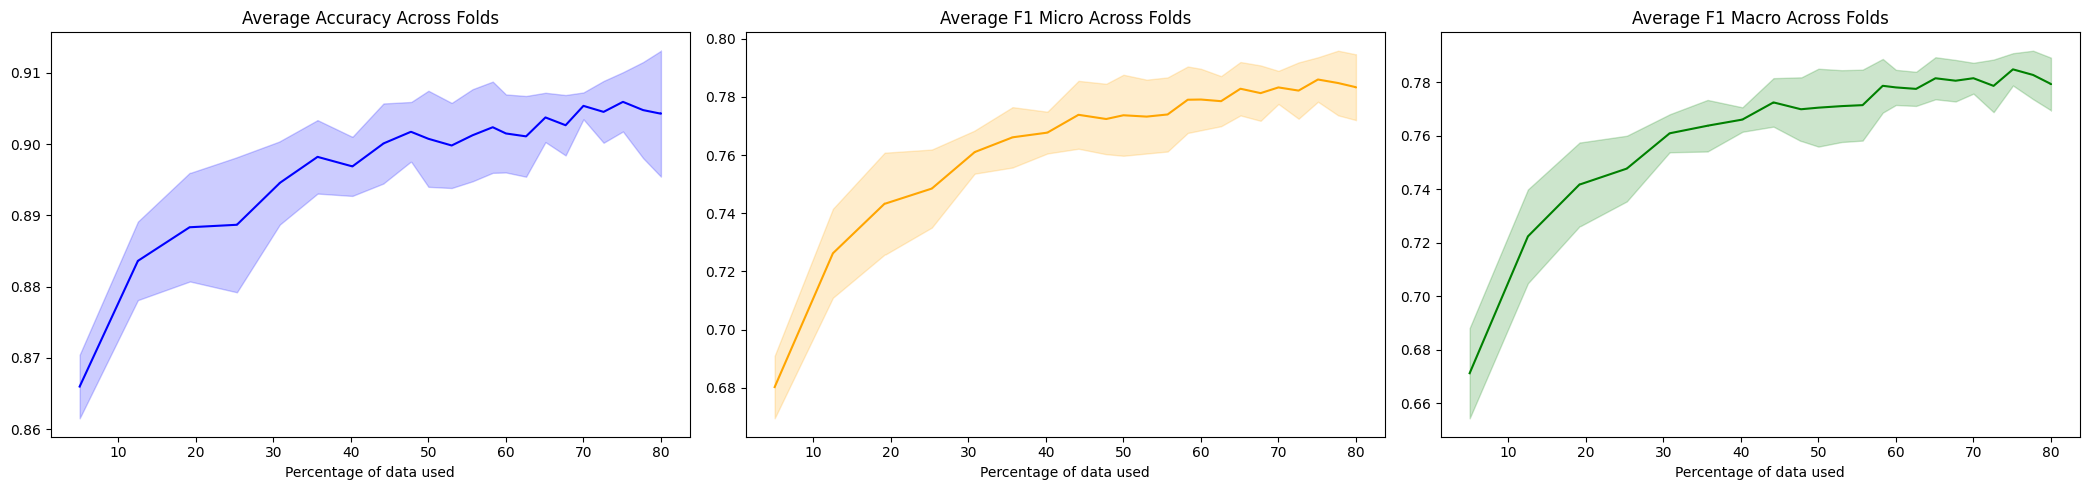

In [15]:
import matplotlib.pyplot as plt
import numpy as np

common_data_points = sorted(list(set(point for fold_points in all_fold_data_used for point in fold_points)))

# Interpolate metrics for each fold to the common data points
avg_accuracies = []
avg_f1_micros = []
avg_f1_macros = []
std_accuracies = []
std_f1_micros = []
std_f1_macros = []

for point in common_data_points:
    point_accuracies = []
    point_f1_micros = []
    point_f1_macros = []
    for i in range(N_SPLITS):
        sorted_indices = np.argsort(all_fold_data_used[i])
        sorted_data = np.array(all_fold_data_used[i])[sorted_indices]
        
        sorted_acc = np.array(all_fold_accuracies[i])[sorted_indices]
        sorted_f1m = np.array(all_fold_f1_micros[i])[sorted_indices]
        sorted_f1ma = np.array(all_fold_f1_macros[i])[sorted_indices]
        
        # Use interpolation to estimate the metric value at the common 'point'
        point_accuracies.append(np.interp(point, sorted_data, sorted_acc))
        point_f1_micros.append(np.interp(point, sorted_data, sorted_f1m))
        point_f1_macros.append(np.interp(point, sorted_data, sorted_f1ma))
    
    avg_accuracies.append(np.mean(point_accuracies))
    avg_f1_micros.append(np.mean(point_f1_micros))
    avg_f1_macros.append(np.mean(point_f1_macros))
    
    std_accuracies.append(np.std(point_accuracies))
    std_f1_micros.append(np.std(point_f1_micros))
    std_f1_macros.append(np.std(point_f1_macros))

# Convert to numpy arrays for easier plotting
avg_accuracies = np.array(avg_accuracies)
avg_f1_micros = np.array(avg_f1_micros)
avg_f1_macros = np.array(avg_f1_macros)
std_accuracies = np.array(std_accuracies)
std_f1_micros = np.array(std_f1_micros)
std_f1_macros = np.array(std_f1_macros)

fig, axs = plt.subplots(1, 3, figsize=(21, 5))
data_used_percent = [round(data / len(X) * 100, 1) for data in common_data_points]

# Plot for Accuracy
axs[0].plot(data_used_percent, avg_accuracies, label="Avg Accuracy", color="blue")
axs[0].fill_between(data_used_percent, avg_accuracies - std_accuracies, avg_accuracies + std_accuracies, color='blue', alpha=0.2)
axs[0].set_xlabel("Percentage of data used")
axs[0].set_title("Average Accuracy Across Folds")

# Plot for F1 Micro
axs[1].plot(data_used_percent, avg_f1_micros, label="Avg F1 Micro", color="orange")
axs[1].fill_between(data_used_percent, avg_f1_micros - std_f1_micros, avg_f1_micros + std_f1_micros, color='orange', alpha=0.2)
axs[1].set_xlabel("Percentage of data used")
axs[1].set_title("Average F1 Micro Across Folds")

# Plot for F1 Macro
axs[2].plot(data_used_percent, avg_f1_macros, label="Avg F1 Macro", color="green")
axs[2].fill_between(data_used_percent, avg_f1_macros - std_f1_macros, avg_f1_macros + std_f1_macros, color='green', alpha=0.2)
axs[2].set_xlabel("Percentage of data used")
axs[2].set_title("Average F1 Macro Across Folds")

# Adjust layout and show the plots
plt.tight_layout()
plt.show()

for i in range(N_SPLITS):
    result = pd.DataFrame({
        'Data Used': all_fold_data_used[i],
        'Accuracy': all_fold_accuracies[i],
        'F1 Micro': all_fold_f1_micros[i],
        'F1 Macro': all_fold_f1_macros[i],
    })

    result.to_csv(f'results/{filename}-{i+1}-results.csv', index=False)